In [1]:
import os
import random

import torch
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from tqdm import tqdm   # show loops progress

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version from PyTorch: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA version from PyTorch: 12.1


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti SUPER


**SEED**

In [4]:
SEED:int = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**LOAD TRAIN DATA**

In [5]:
# Dataset personalizado para DRIVE
class Dataset(Dataset):
    def __init__(self, image_dir, ground_truth, transform=None, transform_img=None):
        self.image_dir = image_dir
        self.ground_truth_dir = ground_truth
        self.image_filenames = os.listdir(image_dir)  
        self.mask_filenames = os.listdir(ground_truth)   
        self.transform = transform
        self.transform_img = transform_img

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        ground_truth_path = os.path.join(self.ground_truth_dir, self.mask_filenames[idx])
        
        image = Image.open(image_path).convert('RGB')
        ground_truth = Image.open(ground_truth_path).convert('L')  # gt to grayscale
        
        # image to tensor (needed to concatenate and more)
        image = transforms.ToTensor()(image)
        ground_truth = transforms.ToTensor()(ground_truth)
        
        if self.transform:        # exactly same transformations to image and gt
            # Concatenate along channel dimension.
            # Here, dim=0 is the channel dimension (not the batch dim) (here we have [C, H, W])
            image_and_gt = torch.cat([image, ground_truth], dim=0) 
            
            # Transform together
            transformed = self.transform(image_and_gt)

            # Slice the tensors out
            image = transformed[:3, :, :]    
            ground_truth = (transformed[3:, :, :] > 0.5).float()       # binarize !!!
        
        
        if self.transform_img:       # transformations only for images
            image = self.transform_img(image)
            

        return image, ground_truth, self.image_filenames[idx]

In [6]:
# Routes for training data
image_dir = './data/CHASE/training/images'
ground_truth_dir = './data/CHASE/training/2nd_manual'

''' # Just compute the mean and std
from torchvision import datasets
# calculate mean and std
dataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

NORM_MEAN = 0.
NORM_STD = 0.
for images, _, _ in dataloader:
    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)
    NORM_STD += images.std([0, 2, 3])    # channels std

NORM_MEAN /= len(dataloader)
NORM_STD /= len(dataloader)

print(f"Mean: {NORM_MEAN}")
print(f"Std: {NORM_STD}")'''

' # Just compute the mean and std\nfrom torchvision import datasets\n# calculate mean and std\ndataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)\n\nNORM_MEAN = 0.\nNORM_STD = 0.\nfor images, _, _ in dataloader:\n    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)\n    NORM_STD += images.std([0, 2, 3])    # channels std\n\nNORM_MEAN /= len(dataloader)\nNORM_STD /= len(dataloader)\n\nprint(f"Mean: {NORM_MEAN}")\nprint(f"Std: {NORM_STD}")'

In [7]:
IMG_SIZE:int = 512
DATA_AUG_PROB:float = 0.85

from torchvision.transforms import v2

# transforms for images and its ground truth segmentations (same for both)
transform = v2.Compose([
    v2.RandomApply([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        #v2.RandomZoomOut(fill=0, p=0.2), 
        v2.RandomAffine(degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.5, 1.5)),
        #v2.RandomResizedCrop(IMG_SIZE),
        #v2.ElasticTransform(alpha=15.0),
        #v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        
    ], p=DATA_AUG_PROB),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    
    # transforms.Grayscale(num_output_channels=1),       # we want rgb    
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])

# transform just for the image
transform_img = v2.Compose([
    v2.RandomApply([
        v2.ColorJitter(brightness=[0.6, 1.2], contrast=[0.3, 1.3], saturation=[0.5, 1.3], hue=0.015),
        v2.RandomAdjustSharpness(sharpness_factor=1.5),
        #v2.GaussianNoise(),

    ], p=DATA_AUG_PROB),
     
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])


dataset = Dataset(image_dir, ground_truth_dir, transform=transform, transform_img=transform_img)

In [8]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)
for img, gt, _ in example_loader:
    print(img.shape)
    print(gt.shape)
    print("\n")
    break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])




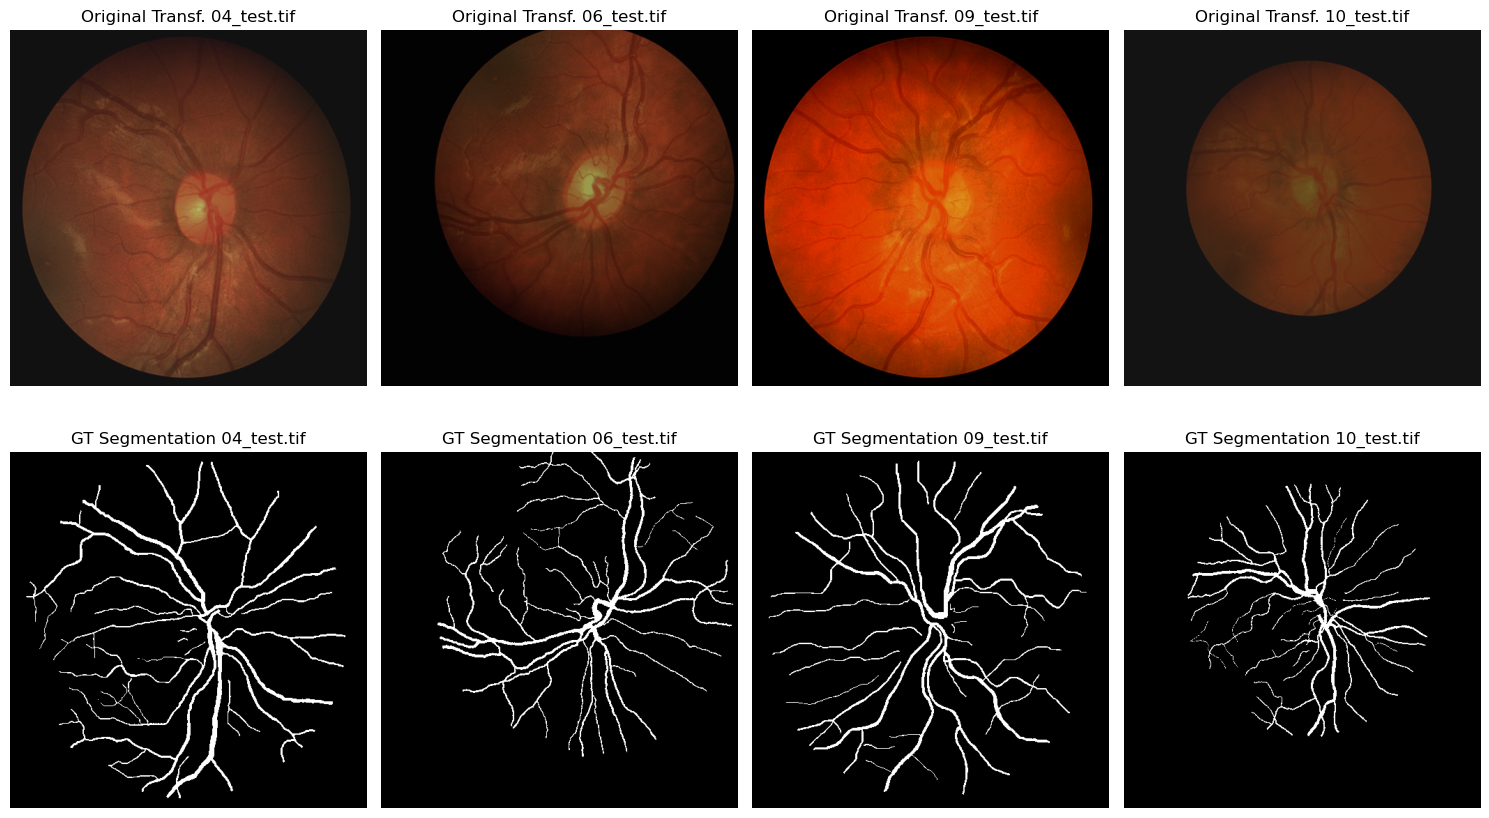

In [9]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Obtener algunas imágenes y máscaras del example_loader
data_iter = iter(example_loader)
images, ground_truth, img_name = next(data_iter)

# Convertir los tensores a formato numpy para visualizarlos
images = images.numpy().transpose(0, 2, 3, 1)  # [N, C, H, W] a [N, H, W, C]
ground_truth = ground_truth.numpy()  # [N, H, W] para las máscaras

# Eliminar la dimensión extra (1, H, W) de las máscaras
ground_truth = np.squeeze(ground_truth)  # Esto convierte la forma (1, H, W) a (H, W)

# Visualizar las imágenes en la fila superior y las máscaras en la fila inferior
fig, axes = plt.subplots(2, 4, figsize=(15, 9))  # 2 filas, 4 columnas (imágenes arriba y máscaras abajo)

for i in range(4):
    # Mostrar la imagen en la fila superior
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original Transf. {img_name[i]}')
    
    # Mostrar la máscara en la fila inferior
    axes[1, i].imshow(ground_truth[i], cmap='gray')  # show as grayscale
    axes[1, i].axis('off')
    axes[1, i].set_title(f'GT Segmentation {img_name[i]}')

plt.tight_layout()
plt.show()

**DATA SPLITTING**

In [10]:
VAL_PERCENT:float = 0.2            # Percentage of dataset intended for validation (rest is for training) 
BATCH_SIZE:int = 2

# Split into train / validation partitions
val_size = int(len(dataset) * VAL_PERCENT)     # number of samples for validation
train_size = len(dataset) - val_size           # number of samples for training
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print('Training set has {} instances'.format(train_size))
print('Validation set has {} instances'.format(val_size))

Training set has 16 instances
Validation set has 4 instances


In [11]:
sample_image, sample_gt, _ = train_set[0]

NUM_CHANNELS_IN:int = sample_image.size(0)  
NUM_CHANNELS_OUT:int = sample_gt.size(0)

print(f"Number of channels in input: {NUM_CHANNELS_IN}")
print(f"Number of channels in output: {NUM_CHANNELS_OUT}")

Number of channels in input: 3
Number of channels in output: 1


**CREATE MODEL**

In [12]:
# from unet import UNet
# model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)

# from vig import ViGClassifier
# NUM_PATCHES:int = 196    #196
# PATCH_SIZE:int = int(IMG_SIZE//np.sqrt(NUM_PATCHES))
# print(f"{PATCH_SIZE=}")
# model = ViGClassifier(in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
#                    n_classes = NUM_CHANNELS_OUT,                                  # number of classes to predict
#                    num_patches = NUM_PATCHES,                                      
#                    patch_size = PATCH_SIZE,
#                    output_size = IMG_SIZE,
#                    out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
#                    num_ViGBlocks=12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)
#                    hidden_layer=1024,
#                    num_edges=7,                                                   # number of neigbours per node
#                    head_num=2,
#                   )


from vig_unet import ViGUNet
NUM_PATCHES:int = 14*14   #196         # ONLY PERFECT SQUARES
PATCH_SIZE:int = int(IMG_SIZE//np.sqrt(NUM_PATCHES))
model = ViGUNet(n_channels = NUM_CHANNELS_IN,
                n_classes = NUM_CHANNELS_OUT,                 # number of classes to predict
                in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
                out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
                num_patches = NUM_PATCHES,
                num_ViGBlocks = 12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)                                      
                num_edges = 9,   #9                                              # number of neigbours per node
                head_num = 1,    #1
                patch_size = PATCH_SIZE,
                output_size = IMG_SIZE,
                )


# cuda if available, cpu if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device.type=}")
model.to(device)      # move to cuda if possible

#from torchsummary import summary
#summary(model, (NUM_CHANNELS_IN, IMG_SIZE, IMG_SIZE))

device.type='cuda'


ViGUNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128

**SOME HYPERPARAMETERS, SAVE PATH, CUDA**

In [13]:
EPOCHS:int = 1000

# save best model state path
SAVE_PATH = "./trained_models"
       

# LOSS FUNCTION -----------------------------------------------------
from utils.loss_functions import DiceLoss, DiceBCELoss, DiceBCELossWithTopology
#(need sigmoid at the end of network)

#loss_fn = torch.nn.BCELoss()        # binary cross-entropy loss 
#loss_fn = DiceLoss()
loss_fn = DiceBCELoss(bce_weight=0.5)      # weight of BCE
#loss_fn = DiceBCELossWithTopology(bce_weight=0.5, topology_weight=0.25, image_pixels=IMG_SIZE*IMG_SIZE)


# OPTIMIZER ---------------------------------------------------------
LEARNING_RATE:float = 0.001
MOMENTUM:float = 0.9
WEIGHT_DECAY:float = 1e-2

#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

optimizer = torch.optim.AdamW([
    {'params': model.parameters()},  # Parámetros del modelo
    {'params': loss_fn.parameters()}  # Parámetros de la pérdida
], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

**TRAIN FUNCTION**

In [14]:
def training_loop(epochs, model, train_dataloader, val_dataloader, 
                  loss_fn, optimizer, save_path, patience=30):
    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy':[], 'val_accuracy':[]}
    best_val_loss = float('inf')  # Initialize to infinity
    best_model_state = None
    datetime_start = datetime.now()
    
    early_stopping_counter = 0  # Counter for early stopping

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        train_correct_pred = 0
        total_train_pred = 0
        
        for data in tqdm(train_dataloader):      # for each training batch
            
            img, ground_truth, _ = data
            img, ground_truth = img.to(device), ground_truth.to(device)     # move to cuda, if possible
            
            pred = model(img)
            # print(f"Pred shape: {pred.shape}, Ground truth shape: {ground_truth.shape}")   # debug
            # print(torch.max(pred))
            # print(torch.min(pred))
            # print(f"Pred device: {pred.device}, Ground truth device: {ground_truth.device}")
            # print(f"Pred type: {type(pred)}")
            # print(f"Pred content: {pred}")

            # print(f"Ground truth values: {ground_truth.unique()}")
            # print("\n")

            loss = loss_fn(pred, ground_truth)
            # print(loss)
            # print(loss.shape)
            running_train_loss += loss.item()
            train_correct_pred += ((pred > 0.5).float() == ground_truth).sum()      # add number of correct predictions
            total_train_pred += IMG_SIZE*IMG_SIZE*len(img)            # add number of predictions made (pixels per img * number of imgs)
            
            loss.backward()            # calculate gradients
            optimizer.step()           # update model parameters
            optimizer.zero_grad()      # reset gradients
        
        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            val_correct_pred = 0
            total_val_pred = 0
            
            for data in tqdm(val_dataloader):      # for each validation batch
                
                img, ground_truth, _ = data
                img, ground_truth = img.to(device), ground_truth.to(device)       # move to cuda, if possible
                
                pred = model(img)
                loss = loss_fn(pred, ground_truth)
                
                running_val_loss += loss.item()
                val_correct_pred += ((pred > 0.5).float() == ground_truth).sum()         # add number of correct predictions
                total_val_pred += IMG_SIZE*IMG_SIZE*len(img)                     # add number of predictions made (pixels per img * number of imgs)


        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)
        train_acc = train_correct_pred / total_train_pred * 100       # % of average accuracy in training, in this epoch
        val_acc = val_correct_pred / total_val_pred * 100             # % of average accuracy in validation, in this epoch

        history['train_loss'].append(train_loss)         # add metrics in this epoch to the record
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss:.5f} | Validation loss: {val_loss:.5f} | Training accuracy: {train_acc:.2f}% | Validation accuracy: {val_acc:.2f}%')
        print(f"\n")
        
        # Save the model if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model state
            early_stopping_counter = 0   # Reset counter if validation loss improves
        else:
            early_stopping_counter += 1
            print(f"Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{patience}")
        
        # Stop training if patience is exceeded
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break
        
    # Save the best model state
    if best_model_state is not None:
        model_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)
        torch.save(best_model_state, model_path)    
        print(f'Best model saved at {model_path}')
    
    # save history (dictionary)
    history_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)+'_history'
    torch.save(history, history_path)
    print(f'\nHistory saved at {history_path}')
    
    model.eval()
    return history

In [15]:
# TRAIN THE CURRENT MODEL
start_time = datetime.now()

PATIENCE = 100

history = training_loop(EPOCHS, model, train_loader, val_loader, 
                        loss_fn, optimizer, SAVE_PATH, PATIENCE)

end_time = datetime.now()
print(f"\nTraining duration: {end_time - start_time}")

100%|██████████| 2/2 [00:00<00:00,  7.93it/s]


Epoch: 1/1000 | Training loss: 0.60162 | Validation loss: 0.60810 | Training accuracy: 92.63% | Validation accuracy: 93.25%




100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


Epoch: 2/1000 | Training loss: 0.59955 | Validation loss: 0.60692 | Training accuracy: 93.28% | Validation accuracy: 93.63%




100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


Epoch: 3/1000 | Training loss: 0.59741 | Validation loss: 0.59195 | Training accuracy: 93.79% | Validation accuracy: 94.34%




100%|██████████| 2/2 [00:00<00:00,  6.86it/s]


Epoch: 4/1000 | Training loss: 0.58276 | Validation loss: 0.57490 | Training accuracy: 93.08% | Validation accuracy: 94.99%




100%|██████████| 2/2 [00:00<00:00,  7.76it/s]


Epoch: 5/1000 | Training loss: 0.57689 | Validation loss: 0.58375 | Training accuracy: 94.10% | Validation accuracy: 93.85%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Epoch: 6/1000 | Training loss: 0.56225 | Validation loss: 0.55723 | Training accuracy: 94.00% | Validation accuracy: 90.39%




100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Epoch: 7/1000 | Training loss: 0.54262 | Validation loss: 0.56284 | Training accuracy: 93.66% | Validation accuracy: 93.11%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


Epoch: 8/1000 | Training loss: 0.52139 | Validation loss: 0.51647 | Training accuracy: 92.87% | Validation accuracy: 93.18%




100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


Epoch: 9/1000 | Training loss: 0.49576 | Validation loss: 0.48803 | Training accuracy: 93.30% | Validation accuracy: 92.35%




100%|██████████| 2/2 [00:00<00:00,  7.39it/s]


Epoch: 10/1000 | Training loss: 0.47060 | Validation loss: 0.55592 | Training accuracy: 94.05% | Validation accuracy: 93.00%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  7.09it/s]


Epoch: 11/1000 | Training loss: 0.44473 | Validation loss: 0.53471 | Training accuracy: 93.39% | Validation accuracy: 94.14%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  6.79it/s]


Epoch: 12/1000 | Training loss: 0.41668 | Validation loss: 0.43046 | Training accuracy: 93.61% | Validation accuracy: 92.33%




100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Epoch: 13/1000 | Training loss: 0.39211 | Validation loss: 0.45822 | Training accuracy: 93.52% | Validation accuracy: 93.47%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  6.63it/s]


Epoch: 14/1000 | Training loss: 0.36624 | Validation loss: 0.43375 | Training accuracy: 94.18% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  7.07it/s]


Epoch: 15/1000 | Training loss: 0.36211 | Validation loss: 0.45011 | Training accuracy: 93.37% | Validation accuracy: 93.07%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Epoch: 16/1000 | Training loss: 0.34636 | Validation loss: 0.40342 | Training accuracy: 93.40% | Validation accuracy: 92.30%




100%|██████████| 2/2 [00:00<00:00,  7.63it/s]


Epoch: 17/1000 | Training loss: 0.33417 | Validation loss: 0.34878 | Training accuracy: 92.93% | Validation accuracy: 95.47%




100%|██████████| 2/2 [00:00<00:00,  7.64it/s]


Epoch: 18/1000 | Training loss: 0.34301 | Validation loss: 0.32709 | Training accuracy: 94.28% | Validation accuracy: 93.24%




100%|██████████| 2/2 [00:00<00:00,  7.96it/s]


Epoch: 19/1000 | Training loss: 0.33330 | Validation loss: 0.32866 | Training accuracy: 92.96% | Validation accuracy: 94.33%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


Epoch: 20/1000 | Training loss: 0.34983 | Validation loss: 0.47291 | Training accuracy: 93.85% | Validation accuracy: 92.80%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Epoch: 21/1000 | Training loss: 0.33470 | Validation loss: 0.40831 | Training accuracy: 93.34% | Validation accuracy: 92.72%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Epoch: 22/1000 | Training loss: 0.33157 | Validation loss: 0.40466 | Training accuracy: 93.03% | Validation accuracy: 93.41%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Epoch: 23/1000 | Training loss: 0.33872 | Validation loss: 0.41747 | Training accuracy: 93.84% | Validation accuracy: 90.79%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  7.87it/s]


Epoch: 24/1000 | Training loss: 0.32817 | Validation loss: 0.33990 | Training accuracy: 93.68% | Validation accuracy: 94.07%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  7.15it/s]


Epoch: 25/1000 | Training loss: 0.32825 | Validation loss: 0.38557 | Training accuracy: 93.08% | Validation accuracy: 91.21%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  6.85it/s]


Epoch: 26/1000 | Training loss: 0.31077 | Validation loss: 0.34917 | Training accuracy: 93.86% | Validation accuracy: 93.11%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Epoch: 27/1000 | Training loss: 0.33075 | Validation loss: 0.34405 | Training accuracy: 93.83% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  7.12it/s]


Epoch: 28/1000 | Training loss: 0.31948 | Validation loss: 0.41236 | Training accuracy: 95.44% | Validation accuracy: 94.68%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  6.86it/s]


Epoch: 29/1000 | Training loss: 0.32078 | Validation loss: 0.35854 | Training accuracy: 95.45% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Epoch: 30/1000 | Training loss: 0.31060 | Validation loss: 0.38707 | Training accuracy: 96.20% | Validation accuracy: 93.93%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


Epoch: 31/1000 | Training loss: 0.31049 | Validation loss: 0.31349 | Training accuracy: 95.82% | Validation accuracy: 96.15%




100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Epoch: 32/1000 | Training loss: 0.30462 | Validation loss: 0.33930 | Training accuracy: 95.40% | Validation accuracy: 93.85%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Epoch: 33/1000 | Training loss: 0.31155 | Validation loss: 0.37643 | Training accuracy: 95.41% | Validation accuracy: 95.77%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


Epoch: 34/1000 | Training loss: 0.30005 | Validation loss: 0.35246 | Training accuracy: 96.17% | Validation accuracy: 94.51%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


Epoch: 35/1000 | Training loss: 0.30851 | Validation loss: 0.29903 | Training accuracy: 95.89% | Validation accuracy: 97.08%




100%|██████████| 2/2 [00:00<00:00,  7.12it/s]


Epoch: 36/1000 | Training loss: 0.29953 | Validation loss: 0.33139 | Training accuracy: 96.25% | Validation accuracy: 94.65%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Epoch: 37/1000 | Training loss: 0.30434 | Validation loss: 0.40536 | Training accuracy: 95.74% | Validation accuracy: 84.87%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


Epoch: 38/1000 | Training loss: 0.29876 | Validation loss: 0.32983 | Training accuracy: 95.59% | Validation accuracy: 94.20%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  7.07it/s]


Epoch: 39/1000 | Training loss: 0.29114 | Validation loss: 0.29054 | Training accuracy: 96.35% | Validation accuracy: 96.66%




100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Epoch: 40/1000 | Training loss: 0.29553 | Validation loss: 0.29659 | Training accuracy: 96.27% | Validation accuracy: 95.62%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  6.72it/s]


Epoch: 41/1000 | Training loss: 0.28972 | Validation loss: 0.29938 | Training accuracy: 95.83% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  7.67it/s]


Epoch: 42/1000 | Training loss: 0.29864 | Validation loss: 0.34913 | Training accuracy: 96.08% | Validation accuracy: 95.09%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  7.83it/s]


Epoch: 43/1000 | Training loss: 0.29917 | Validation loss: 0.31759 | Training accuracy: 95.47% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  7.68it/s]


Epoch: 44/1000 | Training loss: 0.28944 | Validation loss: 0.29195 | Training accuracy: 95.76% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  7.83it/s]


Epoch: 45/1000 | Training loss: 0.28210 | Validation loss: 0.28650 | Training accuracy: 96.04% | Validation accuracy: 96.06%




100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Epoch: 46/1000 | Training loss: 0.29518 | Validation loss: 0.28244 | Training accuracy: 94.94% | Validation accuracy: 96.89%




100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch: 47/1000 | Training loss: 0.28216 | Validation loss: 0.29320 | Training accuracy: 96.45% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch: 48/1000 | Training loss: 0.28528 | Validation loss: 0.29071 | Training accuracy: 96.28% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch: 49/1000 | Training loss: 0.28300 | Validation loss: 0.28157 | Training accuracy: 95.93% | Validation accuracy: 96.56%




100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Epoch: 50/1000 | Training loss: 0.28163 | Validation loss: 0.27575 | Training accuracy: 96.00% | Validation accuracy: 98.41%




100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


Epoch: 51/1000 | Training loss: 0.28470 | Validation loss: 0.32868 | Training accuracy: 95.66% | Validation accuracy: 95.68%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


Epoch: 52/1000 | Training loss: 0.28616 | Validation loss: 0.37786 | Training accuracy: 95.58% | Validation accuracy: 94.02%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


Epoch: 53/1000 | Training loss: 0.27754 | Validation loss: 0.37847 | Training accuracy: 96.56% | Validation accuracy: 95.21%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


Epoch: 54/1000 | Training loss: 0.27788 | Validation loss: 0.28402 | Training accuracy: 95.90% | Validation accuracy: 95.33%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Epoch: 55/1000 | Training loss: 0.27469 | Validation loss: 0.37431 | Training accuracy: 95.90% | Validation accuracy: 94.52%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


Epoch: 56/1000 | Training loss: 0.27786 | Validation loss: 0.28153 | Training accuracy: 95.71% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


Epoch: 57/1000 | Training loss: 0.26924 | Validation loss: 0.27566 | Training accuracy: 96.83% | Validation accuracy: 96.74%




100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


Epoch: 58/1000 | Training loss: 0.27250 | Validation loss: 0.41253 | Training accuracy: 96.57% | Validation accuracy: 96.01%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Epoch: 59/1000 | Training loss: 0.26752 | Validation loss: 0.29099 | Training accuracy: 97.00% | Validation accuracy: 95.30%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Epoch: 60/1000 | Training loss: 0.27082 | Validation loss: 0.26867 | Training accuracy: 95.84% | Validation accuracy: 96.72%




100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


Epoch: 61/1000 | Training loss: 0.26914 | Validation loss: 0.33695 | Training accuracy: 96.50% | Validation accuracy: 95.75%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


Epoch: 62/1000 | Training loss: 0.26308 | Validation loss: 0.31654 | Training accuracy: 97.16% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


Epoch: 63/1000 | Training loss: 0.27325 | Validation loss: 0.28022 | Training accuracy: 96.01% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Epoch: 64/1000 | Training loss: 0.27430 | Validation loss: 0.31837 | Training accuracy: 95.69% | Validation accuracy: 95.82%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


Epoch: 65/1000 | Training loss: 0.27186 | Validation loss: 0.27675 | Training accuracy: 95.62% | Validation accuracy: 95.54%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


Epoch: 66/1000 | Training loss: 0.27318 | Validation loss: 0.26741 | Training accuracy: 95.69% | Validation accuracy: 97.03%




100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


Epoch: 67/1000 | Training loss: 0.27082 | Validation loss: 0.34515 | Training accuracy: 95.96% | Validation accuracy: 95.83%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


Epoch: 68/1000 | Training loss: 0.26375 | Validation loss: 0.29867 | Training accuracy: 96.14% | Validation accuracy: 95.52%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


Epoch: 69/1000 | Training loss: 0.26907 | Validation loss: 0.27633 | Training accuracy: 95.58% | Validation accuracy: 95.75%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


Epoch: 70/1000 | Training loss: 0.26239 | Validation loss: 0.25575 | Training accuracy: 95.89% | Validation accuracy: 96.75%




100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Epoch: 71/1000 | Training loss: 0.25984 | Validation loss: 0.26767 | Training accuracy: 96.62% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


Epoch: 72/1000 | Training loss: 0.25420 | Validation loss: 0.29347 | Training accuracy: 96.47% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Epoch: 73/1000 | Training loss: 0.26096 | Validation loss: 0.32603 | Training accuracy: 96.78% | Validation accuracy: 93.57%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


Epoch: 74/1000 | Training loss: 0.26798 | Validation loss: 0.25964 | Training accuracy: 96.07% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Epoch: 75/1000 | Training loss: 0.26839 | Validation loss: 0.27910 | Training accuracy: 95.77% | Validation accuracy: 96.04%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


Epoch: 76/1000 | Training loss: 0.25454 | Validation loss: 0.28057 | Training accuracy: 96.78% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.22it/s]


Epoch: 77/1000 | Training loss: 0.26052 | Validation loss: 0.25646 | Training accuracy: 96.25% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Epoch: 78/1000 | Training loss: 0.26802 | Validation loss: 0.26669 | Training accuracy: 95.70% | Validation accuracy: 96.19%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


Epoch: 79/1000 | Training loss: 0.25659 | Validation loss: 0.36490 | Training accuracy: 96.00% | Validation accuracy: 95.78%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


Epoch: 80/1000 | Training loss: 0.25117 | Validation loss: 0.44723 | Training accuracy: 96.39% | Validation accuracy: 93.83%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Epoch: 81/1000 | Training loss: 0.24995 | Validation loss: 0.25803 | Training accuracy: 96.18% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


Epoch: 82/1000 | Training loss: 0.25446 | Validation loss: 0.28325 | Training accuracy: 95.88% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


Epoch: 83/1000 | Training loss: 0.25186 | Validation loss: 0.26583 | Training accuracy: 96.31% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


Epoch: 84/1000 | Training loss: 0.24924 | Validation loss: 0.30888 | Training accuracy: 96.37% | Validation accuracy: 94.58%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


Epoch: 85/1000 | Training loss: 0.25031 | Validation loss: 0.25879 | Training accuracy: 96.38% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


Epoch: 86/1000 | Training loss: 0.25391 | Validation loss: 0.30752 | Training accuracy: 96.13% | Validation accuracy: 96.08%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Epoch: 87/1000 | Training loss: 0.25210 | Validation loss: 0.39500 | Training accuracy: 95.68% | Validation accuracy: 95.46%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


Epoch: 88/1000 | Training loss: 0.25480 | Validation loss: 0.31302 | Training accuracy: 96.01% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


Epoch: 89/1000 | Training loss: 0.25876 | Validation loss: 0.25517 | Training accuracy: 96.04% | Validation accuracy: 96.12%




100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


Epoch: 90/1000 | Training loss: 0.24970 | Validation loss: 0.28131 | Training accuracy: 95.86% | Validation accuracy: 95.99%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


Epoch: 91/1000 | Training loss: 0.24911 | Validation loss: 0.25001 | Training accuracy: 96.09% | Validation accuracy: 95.56%




100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


Epoch: 92/1000 | Training loss: 0.24123 | Validation loss: 0.31905 | Training accuracy: 96.44% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.35it/s]


Epoch: 93/1000 | Training loss: 0.24285 | Validation loss: 0.27907 | Training accuracy: 96.28% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


Epoch: 94/1000 | Training loss: 0.24306 | Validation loss: 0.24868 | Training accuracy: 96.63% | Validation accuracy: 95.92%




100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Epoch: 95/1000 | Training loss: 0.24059 | Validation loss: 0.28961 | Training accuracy: 96.67% | Validation accuracy: 95.58%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch: 96/1000 | Training loss: 0.23933 | Validation loss: 0.25512 | Training accuracy: 96.68% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


Epoch: 97/1000 | Training loss: 0.23998 | Validation loss: 0.24767 | Training accuracy: 96.00% | Validation accuracy: 97.20%




100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


Epoch: 98/1000 | Training loss: 0.23881 | Validation loss: 0.29517 | Training accuracy: 96.23% | Validation accuracy: 93.18%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


Epoch: 99/1000 | Training loss: 0.23889 | Validation loss: 0.24621 | Training accuracy: 96.69% | Validation accuracy: 97.44%




100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Epoch: 100/1000 | Training loss: 0.23622 | Validation loss: 0.27560 | Training accuracy: 96.43% | Validation accuracy: 95.84%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Epoch: 101/1000 | Training loss: 0.23702 | Validation loss: 0.23810 | Training accuracy: 96.53% | Validation accuracy: 96.17%




100%|██████████| 2/2 [00:00<00:00,  4.90it/s]


Epoch: 102/1000 | Training loss: 0.23246 | Validation loss: 0.26465 | Training accuracy: 96.78% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Epoch: 103/1000 | Training loss: 0.23458 | Validation loss: 0.24568 | Training accuracy: 96.82% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


Epoch: 104/1000 | Training loss: 0.22932 | Validation loss: 0.22619 | Training accuracy: 97.06% | Validation accuracy: 98.01%




100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


Epoch: 105/1000 | Training loss: 0.22970 | Validation loss: 0.25769 | Training accuracy: 96.75% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Epoch: 106/1000 | Training loss: 0.24476 | Validation loss: 0.28223 | Training accuracy: 96.04% | Validation accuracy: 94.98%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch: 107/1000 | Training loss: 0.24333 | Validation loss: 0.27173 | Training accuracy: 95.88% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Epoch: 108/1000 | Training loss: 0.23973 | Validation loss: 0.25744 | Training accuracy: 96.11% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch: 109/1000 | Training loss: 0.23953 | Validation loss: 0.24471 | Training accuracy: 96.05% | Validation accuracy: 95.90%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Epoch: 110/1000 | Training loss: 0.23239 | Validation loss: 0.25771 | Training accuracy: 96.52% | Validation accuracy: 96.19%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


Epoch: 111/1000 | Training loss: 0.23751 | Validation loss: 0.23832 | Training accuracy: 96.63% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


Epoch: 112/1000 | Training loss: 0.23824 | Validation loss: 0.27028 | Training accuracy: 96.66% | Validation accuracy: 95.68%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Epoch: 113/1000 | Training loss: 0.23550 | Validation loss: 0.28971 | Training accuracy: 96.68% | Validation accuracy: 95.51%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


Epoch: 114/1000 | Training loss: 0.23731 | Validation loss: 0.22588 | Training accuracy: 95.65% | Validation accuracy: 97.29%




100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


Epoch: 115/1000 | Training loss: 0.23199 | Validation loss: 0.22560 | Training accuracy: 95.98% | Validation accuracy: 97.67%




100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


Epoch: 116/1000 | Training loss: 0.23137 | Validation loss: 0.22965 | Training accuracy: 95.64% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch: 117/1000 | Training loss: 0.22468 | Validation loss: 0.24041 | Training accuracy: 96.89% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Epoch: 118/1000 | Training loss: 0.23304 | Validation loss: 0.23726 | Training accuracy: 96.34% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.42it/s]


Epoch: 119/1000 | Training loss: 0.23524 | Validation loss: 0.22713 | Training accuracy: 96.28% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Epoch: 120/1000 | Training loss: 0.22588 | Validation loss: 0.22594 | Training accuracy: 96.64% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


Epoch: 121/1000 | Training loss: 0.23023 | Validation loss: 0.24076 | Training accuracy: 96.34% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Epoch: 122/1000 | Training loss: 0.22457 | Validation loss: 0.23218 | Training accuracy: 96.89% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


Epoch: 123/1000 | Training loss: 0.22231 | Validation loss: 0.23556 | Training accuracy: 97.06% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


Epoch: 124/1000 | Training loss: 0.23008 | Validation loss: 0.22796 | Training accuracy: 95.97% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  4.36it/s]


Epoch: 125/1000 | Training loss: 0.22158 | Validation loss: 0.24791 | Training accuracy: 96.54% | Validation accuracy: 95.48%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


Epoch: 126/1000 | Training loss: 0.22746 | Validation loss: 0.40825 | Training accuracy: 96.96% | Validation accuracy: 94.11%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  3.80it/s]


Epoch: 127/1000 | Training loss: 0.23192 | Validation loss: 0.25634 | Training accuracy: 96.27% | Validation accuracy: 95.77%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch: 128/1000 | Training loss: 0.22666 | Validation loss: 0.23334 | Training accuracy: 96.46% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Epoch: 129/1000 | Training loss: 0.22190 | Validation loss: 0.22983 | Training accuracy: 96.27% | Validation accuracy: 95.38%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


Epoch: 130/1000 | Training loss: 0.21981 | Validation loss: 0.22371 | Training accuracy: 96.92% | Validation accuracy: 96.83%




100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Epoch: 131/1000 | Training loss: 0.21954 | Validation loss: 0.23365 | Training accuracy: 96.71% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch: 132/1000 | Training loss: 0.21802 | Validation loss: 0.28898 | Training accuracy: 96.16% | Validation accuracy: 96.08%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Epoch: 133/1000 | Training loss: 0.21788 | Validation loss: 0.21107 | Training accuracy: 96.05% | Validation accuracy: 97.31%




100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


Epoch: 134/1000 | Training loss: 0.22654 | Validation loss: 0.22594 | Training accuracy: 96.17% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


Epoch: 135/1000 | Training loss: 0.21682 | Validation loss: 0.24318 | Training accuracy: 96.51% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.37it/s]


Epoch: 136/1000 | Training loss: 0.21413 | Validation loss: 0.21679 | Training accuracy: 96.64% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.37it/s]


Epoch: 137/1000 | Training loss: 0.21806 | Validation loss: 0.41724 | Training accuracy: 96.78% | Validation accuracy: 79.44%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


Epoch: 138/1000 | Training loss: 0.21804 | Validation loss: 0.44864 | Training accuracy: 96.76% | Validation accuracy: 72.67%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


Epoch: 139/1000 | Training loss: 0.21798 | Validation loss: 0.24155 | Training accuracy: 97.39% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Epoch: 140/1000 | Training loss: 0.21640 | Validation loss: 0.26561 | Training accuracy: 97.22% | Validation accuracy: 95.86%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


Epoch: 141/1000 | Training loss: 0.22623 | Validation loss: 0.22486 | Training accuracy: 96.27% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Epoch: 142/1000 | Training loss: 0.22142 | Validation loss: 0.23926 | Training accuracy: 96.10% | Validation accuracy: 95.43%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


Epoch: 143/1000 | Training loss: 0.21683 | Validation loss: 0.21773 | Training accuracy: 96.84% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


Epoch: 144/1000 | Training loss: 0.21286 | Validation loss: 0.23275 | Training accuracy: 97.05% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Epoch: 145/1000 | Training loss: 0.21480 | Validation loss: 0.31442 | Training accuracy: 96.79% | Validation accuracy: 95.37%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


Epoch: 146/1000 | Training loss: 0.21387 | Validation loss: 0.26802 | Training accuracy: 96.11% | Validation accuracy: 94.76%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  4.30it/s]


Epoch: 147/1000 | Training loss: 0.21795 | Validation loss: 0.31156 | Training accuracy: 96.02% | Validation accuracy: 95.22%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


Epoch: 148/1000 | Training loss: 0.20898 | Validation loss: 0.22444 | Training accuracy: 96.82% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


Epoch: 149/1000 | Training loss: 0.21285 | Validation loss: 0.25922 | Training accuracy: 96.92% | Validation accuracy: 94.96%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


Epoch: 150/1000 | Training loss: 0.20971 | Validation loss: 0.20360 | Training accuracy: 96.68% | Validation accuracy: 97.70%




100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch: 151/1000 | Training loss: 0.21094 | Validation loss: 0.21113 | Training accuracy: 96.85% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Epoch: 152/1000 | Training loss: 0.20909 | Validation loss: 0.19767 | Training accuracy: 96.37% | Validation accuracy: 96.95%




100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


Epoch: 153/1000 | Training loss: 0.20747 | Validation loss: 0.20920 | Training accuracy: 97.24% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


Epoch: 154/1000 | Training loss: 0.20564 | Validation loss: 0.21386 | Training accuracy: 96.87% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


Epoch: 155/1000 | Training loss: 0.20499 | Validation loss: 0.20004 | Training accuracy: 96.87% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Epoch: 156/1000 | Training loss: 0.20285 | Validation loss: 0.20665 | Training accuracy: 96.74% | Validation accuracy: 96.55%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch: 157/1000 | Training loss: 0.20492 | Validation loss: 0.20891 | Training accuracy: 96.34% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Epoch: 158/1000 | Training loss: 0.20577 | Validation loss: 0.24890 | Training accuracy: 96.75% | Validation accuracy: 95.95%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


Epoch: 159/1000 | Training loss: 0.20876 | Validation loss: 0.20907 | Training accuracy: 96.59% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.39it/s]


Epoch: 160/1000 | Training loss: 0.20376 | Validation loss: 0.21086 | Training accuracy: 97.06% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch: 161/1000 | Training loss: 0.20389 | Validation loss: 0.19670 | Training accuracy: 96.92% | Validation accuracy: 97.99%




100%|██████████| 2/2 [00:00<00:00,  4.18it/s]


Epoch: 162/1000 | Training loss: 0.20067 | Validation loss: 0.20539 | Training accuracy: 97.55% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


Epoch: 163/1000 | Training loss: 0.20448 | Validation loss: 0.20627 | Training accuracy: 96.95% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Epoch: 164/1000 | Training loss: 0.20652 | Validation loss: 0.20144 | Training accuracy: 96.40% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Epoch: 165/1000 | Training loss: 0.20422 | Validation loss: 0.20247 | Training accuracy: 96.24% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


Epoch: 166/1000 | Training loss: 0.19848 | Validation loss: 0.21451 | Training accuracy: 96.70% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.35it/s]


Epoch: 167/1000 | Training loss: 0.20062 | Validation loss: 0.21090 | Training accuracy: 96.89% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


Epoch: 168/1000 | Training loss: 0.19854 | Validation loss: 0.21448 | Training accuracy: 97.41% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Epoch: 169/1000 | Training loss: 0.20273 | Validation loss: 0.20802 | Training accuracy: 96.52% | Validation accuracy: 96.11%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Epoch: 170/1000 | Training loss: 0.19732 | Validation loss: 0.19135 | Training accuracy: 96.74% | Validation accuracy: 97.38%




100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


Epoch: 171/1000 | Training loss: 0.19865 | Validation loss: 0.19550 | Training accuracy: 96.81% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


Epoch: 172/1000 | Training loss: 0.19436 | Validation loss: 0.20462 | Training accuracy: 97.31% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


Epoch: 173/1000 | Training loss: 0.19703 | Validation loss: 0.22849 | Training accuracy: 97.11% | Validation accuracy: 96.12%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


Epoch: 174/1000 | Training loss: 0.19830 | Validation loss: 0.19828 | Training accuracy: 96.58% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


Epoch: 175/1000 | Training loss: 0.19957 | Validation loss: 0.20454 | Training accuracy: 96.18% | Validation accuracy: 95.94%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


Epoch: 176/1000 | Training loss: 0.20379 | Validation loss: 0.20899 | Training accuracy: 96.70% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  5.03it/s]


Epoch: 177/1000 | Training loss: 0.19867 | Validation loss: 0.19142 | Training accuracy: 97.04% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Epoch: 178/1000 | Training loss: 0.20379 | Validation loss: 0.20428 | Training accuracy: 96.28% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.42it/s]


Epoch: 179/1000 | Training loss: 0.19526 | Validation loss: 0.22059 | Training accuracy: 97.08% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


Epoch: 180/1000 | Training loss: 0.19489 | Validation loss: 0.19009 | Training accuracy: 96.76% | Validation accuracy: 97.51%




100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Epoch: 181/1000 | Training loss: 0.19947 | Validation loss: 0.23341 | Training accuracy: 96.27% | Validation accuracy: 95.84%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


Epoch: 182/1000 | Training loss: 0.19458 | Validation loss: 0.20161 | Training accuracy: 96.94% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


Epoch: 183/1000 | Training loss: 0.19717 | Validation loss: 0.19926 | Training accuracy: 96.94% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch: 184/1000 | Training loss: 0.19809 | Validation loss: 0.19644 | Training accuracy: 96.38% | Validation accuracy: 95.82%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


Epoch: 185/1000 | Training loss: 0.19683 | Validation loss: 0.22618 | Training accuracy: 96.36% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Epoch: 186/1000 | Training loss: 0.19608 | Validation loss: 0.23884 | Training accuracy: 96.91% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


Epoch: 187/1000 | Training loss: 0.19472 | Validation loss: 0.19904 | Training accuracy: 97.10% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch: 188/1000 | Training loss: 0.19292 | Validation loss: 0.18737 | Training accuracy: 96.85% | Validation accuracy: 97.28%




100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Epoch: 189/1000 | Training loss: 0.19186 | Validation loss: 0.18676 | Training accuracy: 97.05% | Validation accuracy: 98.33%




100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Epoch: 190/1000 | Training loss: 0.19444 | Validation loss: 0.20901 | Training accuracy: 96.58% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Epoch: 191/1000 | Training loss: 0.19080 | Validation loss: 0.20051 | Training accuracy: 96.66% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


Epoch: 192/1000 | Training loss: 0.18895 | Validation loss: 0.20757 | Training accuracy: 96.92% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


Epoch: 193/1000 | Training loss: 0.19330 | Validation loss: 0.23449 | Training accuracy: 96.61% | Validation accuracy: 95.97%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


Epoch: 194/1000 | Training loss: 0.18946 | Validation loss: 0.19990 | Training accuracy: 96.72% | Validation accuracy: 96.38%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


Epoch: 195/1000 | Training loss: 0.19220 | Validation loss: 0.19523 | Training accuracy: 96.56% | Validation accuracy: 96.09%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


Epoch: 196/1000 | Training loss: 0.18735 | Validation loss: 0.19101 | Training accuracy: 97.59% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


Epoch: 197/1000 | Training loss: 0.19419 | Validation loss: 0.40569 | Training accuracy: 96.93% | Validation accuracy: 94.73%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.39it/s]


Epoch: 198/1000 | Training loss: 0.19117 | Validation loss: 0.19448 | Training accuracy: 96.85% | Validation accuracy: 98.33%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


Epoch: 199/1000 | Training loss: 0.19192 | Validation loss: 0.18431 | Training accuracy: 96.55% | Validation accuracy: 97.16%




100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


Epoch: 200/1000 | Training loss: 0.19029 | Validation loss: 0.19633 | Training accuracy: 97.48% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


Epoch: 201/1000 | Training loss: 0.19337 | Validation loss: 0.23105 | Training accuracy: 96.69% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


Epoch: 202/1000 | Training loss: 0.18982 | Validation loss: 0.19824 | Training accuracy: 96.89% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


Epoch: 203/1000 | Training loss: 0.19008 | Validation loss: 0.19721 | Training accuracy: 96.67% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


Epoch: 204/1000 | Training loss: 0.18596 | Validation loss: 0.18169 | Training accuracy: 96.94% | Validation accuracy: 96.81%




100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Epoch: 205/1000 | Training loss: 0.19181 | Validation loss: 0.18311 | Training accuracy: 96.54% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  6.68it/s]


Epoch: 206/1000 | Training loss: 0.18957 | Validation loss: 0.20071 | Training accuracy: 96.84% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  7.84it/s]


Epoch: 207/1000 | Training loss: 0.18981 | Validation loss: 0.18263 | Training accuracy: 96.75% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.03it/s]


Epoch: 208/1000 | Training loss: 0.18634 | Validation loss: 0.19552 | Training accuracy: 96.81% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Epoch: 209/1000 | Training loss: 0.18426 | Validation loss: 0.18208 | Training accuracy: 97.38% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  6.92it/s]


Epoch: 210/1000 | Training loss: 0.18376 | Validation loss: 0.18708 | Training accuracy: 97.13% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


Epoch: 211/1000 | Training loss: 0.18157 | Validation loss: 0.18556 | Training accuracy: 97.07% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


Epoch: 212/1000 | Training loss: 0.18500 | Validation loss: 0.18409 | Training accuracy: 96.61% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Epoch: 213/1000 | Training loss: 0.18093 | Validation loss: 0.18444 | Training accuracy: 97.04% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


Epoch: 214/1000 | Training loss: 0.18454 | Validation loss: 0.20747 | Training accuracy: 97.25% | Validation accuracy: 95.98%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


Epoch: 215/1000 | Training loss: 0.18191 | Validation loss: 0.18397 | Training accuracy: 97.20% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  3.98it/s]


Epoch: 216/1000 | Training loss: 0.18594 | Validation loss: 0.20127 | Training accuracy: 96.80% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  4.32it/s]


Epoch: 217/1000 | Training loss: 0.17948 | Validation loss: 0.19275 | Training accuracy: 97.01% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


Epoch: 218/1000 | Training loss: 0.17757 | Validation loss: 0.18040 | Training accuracy: 97.24% | Validation accuracy: 97.90%




100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


Epoch: 219/1000 | Training loss: 0.18183 | Validation loss: 0.18355 | Training accuracy: 96.78% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]


Epoch: 220/1000 | Training loss: 0.18129 | Validation loss: 0.24923 | Training accuracy: 96.92% | Validation accuracy: 95.71%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Epoch: 221/1000 | Training loss: 0.18456 | Validation loss: 0.19702 | Training accuracy: 96.74% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


Epoch: 222/1000 | Training loss: 0.18260 | Validation loss: 0.24095 | Training accuracy: 96.88% | Validation accuracy: 95.46%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


Epoch: 223/1000 | Training loss: 0.18138 | Validation loss: 0.17494 | Training accuracy: 97.22% | Validation accuracy: 96.93%




100%|██████████| 2/2 [00:00<00:00,  3.86it/s]


Epoch: 224/1000 | Training loss: 0.18404 | Validation loss: 0.17752 | Training accuracy: 96.47% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Epoch: 225/1000 | Training loss: 0.17959 | Validation loss: 0.18404 | Training accuracy: 96.96% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Epoch: 226/1000 | Training loss: 0.18048 | Validation loss: 0.17884 | Training accuracy: 96.75% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Epoch: 227/1000 | Training loss: 0.17824 | Validation loss: 0.18164 | Training accuracy: 97.17% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.37it/s]


Epoch: 228/1000 | Training loss: 0.17494 | Validation loss: 0.17616 | Training accuracy: 97.36% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


Epoch: 229/1000 | Training loss: 0.17846 | Validation loss: 0.18020 | Training accuracy: 97.02% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


Epoch: 230/1000 | Training loss: 0.17643 | Validation loss: 0.17827 | Training accuracy: 96.95% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


Epoch: 231/1000 | Training loss: 0.17917 | Validation loss: 0.17928 | Training accuracy: 97.30% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


Epoch: 232/1000 | Training loss: 0.17544 | Validation loss: 0.17941 | Training accuracy: 97.20% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


Epoch: 233/1000 | Training loss: 0.18013 | Validation loss: 0.17866 | Training accuracy: 96.73% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  4.35it/s]


Epoch: 234/1000 | Training loss: 0.17632 | Validation loss: 0.18802 | Training accuracy: 97.04% | Validation accuracy: 98.44%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


Epoch: 235/1000 | Training loss: 0.17570 | Validation loss: 0.18112 | Training accuracy: 97.33% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


Epoch: 236/1000 | Training loss: 0.17634 | Validation loss: 0.17295 | Training accuracy: 97.01% | Validation accuracy: 97.00%




100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


Epoch: 237/1000 | Training loss: 0.17892 | Validation loss: 0.17277 | Training accuracy: 96.57% | Validation accuracy: 97.11%




100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


Epoch: 238/1000 | Training loss: 0.17466 | Validation loss: 0.19308 | Training accuracy: 97.46% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


Epoch: 239/1000 | Training loss: 0.17657 | Validation loss: 0.21312 | Training accuracy: 96.62% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


Epoch: 240/1000 | Training loss: 0.17886 | Validation loss: 0.17582 | Training accuracy: 96.70% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


Epoch: 241/1000 | Training loss: 0.17817 | Validation loss: 0.24609 | Training accuracy: 96.79% | Validation accuracy: 95.95%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


Epoch: 242/1000 | Training loss: 0.18126 | Validation loss: 0.23603 | Training accuracy: 96.82% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


Epoch: 243/1000 | Training loss: 0.18272 | Validation loss: 0.21333 | Training accuracy: 96.33% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Epoch: 244/1000 | Training loss: 0.17735 | Validation loss: 0.17322 | Training accuracy: 96.65% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Epoch: 245/1000 | Training loss: 0.17720 | Validation loss: 0.16634 | Training accuracy: 97.39% | Validation accuracy: 98.04%




100%|██████████| 2/2 [00:00<00:00,  4.30it/s]


Epoch: 246/1000 | Training loss: 0.17704 | Validation loss: 0.17091 | Training accuracy: 96.77% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


Epoch: 247/1000 | Training loss: 0.17550 | Validation loss: 0.18759 | Training accuracy: 96.58% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


Epoch: 248/1000 | Training loss: 0.17565 | Validation loss: 0.17455 | Training accuracy: 97.13% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch: 249/1000 | Training loss: 0.17650 | Validation loss: 0.19161 | Training accuracy: 97.23% | Validation accuracy: 96.04%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


Epoch: 250/1000 | Training loss: 0.17789 | Validation loss: 0.17072 | Training accuracy: 96.93% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  3.89it/s]


Epoch: 251/1000 | Training loss: 0.17653 | Validation loss: 0.18739 | Training accuracy: 96.90% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.36it/s]


Epoch: 252/1000 | Training loss: 0.17516 | Validation loss: 0.17234 | Training accuracy: 97.38% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Epoch: 253/1000 | Training loss: 0.17707 | Validation loss: 0.20745 | Training accuracy: 97.16% | Validation accuracy: 95.76%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.41it/s]


Epoch: 254/1000 | Training loss: 0.18075 | Validation loss: 0.25793 | Training accuracy: 97.06% | Validation accuracy: 95.95%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Epoch: 255/1000 | Training loss: 0.18757 | Validation loss: 0.23168 | Training accuracy: 96.17% | Validation accuracy: 94.69%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


Epoch: 256/1000 | Training loss: 0.18040 | Validation loss: 0.19266 | Training accuracy: 97.05% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


Epoch: 257/1000 | Training loss: 0.17629 | Validation loss: 0.22419 | Training accuracy: 97.16% | Validation accuracy: 94.87%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


Epoch: 258/1000 | Training loss: 0.17859 | Validation loss: 0.20421 | Training accuracy: 96.54% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  4.21it/s]


Epoch: 259/1000 | Training loss: 0.17549 | Validation loss: 0.21513 | Training accuracy: 97.11% | Validation accuracy: 95.59%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


Epoch: 260/1000 | Training loss: 0.18497 | Validation loss: 0.32007 | Training accuracy: 96.50% | Validation accuracy: 94.44%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


Epoch: 261/1000 | Training loss: 0.17658 | Validation loss: 0.20802 | Training accuracy: 97.47% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  4.37it/s]


Epoch: 262/1000 | Training loss: 0.17676 | Validation loss: 0.19284 | Training accuracy: 97.22% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]


Epoch: 263/1000 | Training loss: 0.17824 | Validation loss: 0.20095 | Training accuracy: 96.71% | Validation accuracy: 95.43%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Epoch: 264/1000 | Training loss: 0.17519 | Validation loss: 0.18343 | Training accuracy: 97.10% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


Epoch: 265/1000 | Training loss: 0.17687 | Validation loss: 0.21096 | Training accuracy: 96.64% | Validation accuracy: 95.45%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


Epoch: 266/1000 | Training loss: 0.17934 | Validation loss: 0.17963 | Training accuracy: 96.81% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


Epoch: 267/1000 | Training loss: 0.17721 | Validation loss: 0.17308 | Training accuracy: 96.87% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


Epoch: 268/1000 | Training loss: 0.17514 | Validation loss: 0.21422 | Training accuracy: 97.19% | Validation accuracy: 95.88%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch: 269/1000 | Training loss: 0.17121 | Validation loss: 0.16694 | Training accuracy: 96.80% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


Epoch: 270/1000 | Training loss: 0.17299 | Validation loss: 0.17241 | Training accuracy: 96.84% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


Epoch: 271/1000 | Training loss: 0.17280 | Validation loss: 0.20075 | Training accuracy: 97.23% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch: 272/1000 | Training loss: 0.16590 | Validation loss: 0.16881 | Training accuracy: 97.38% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


Epoch: 273/1000 | Training loss: 0.16712 | Validation loss: 0.16152 | Training accuracy: 97.36% | Validation accuracy: 97.46%




100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Epoch: 274/1000 | Training loss: 0.16860 | Validation loss: 0.21054 | Training accuracy: 97.00% | Validation accuracy: 95.90%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.21it/s]


Epoch: 275/1000 | Training loss: 0.17160 | Validation loss: 0.18094 | Training accuracy: 97.00% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


Epoch: 276/1000 | Training loss: 0.16856 | Validation loss: 0.16713 | Training accuracy: 97.12% | Validation accuracy: 98.33%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.42it/s]


Epoch: 277/1000 | Training loss: 0.16871 | Validation loss: 0.17200 | Training accuracy: 97.06% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


Epoch: 278/1000 | Training loss: 0.16963 | Validation loss: 0.17012 | Training accuracy: 96.75% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch: 279/1000 | Training loss: 0.16990 | Validation loss: 0.22901 | Training accuracy: 96.72% | Validation accuracy: 96.08%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


Epoch: 280/1000 | Training loss: 0.16655 | Validation loss: 0.16924 | Training accuracy: 96.85% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


Epoch: 281/1000 | Training loss: 0.16592 | Validation loss: 0.17761 | Training accuracy: 97.16% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.32it/s]


Epoch: 282/1000 | Training loss: 0.16639 | Validation loss: 0.17664 | Training accuracy: 97.16% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Epoch: 283/1000 | Training loss: 0.16593 | Validation loss: 0.16323 | Training accuracy: 97.13% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


Epoch: 284/1000 | Training loss: 0.16386 | Validation loss: 0.16551 | Training accuracy: 97.59% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Epoch: 285/1000 | Training loss: 0.16469 | Validation loss: 0.18053 | Training accuracy: 97.20% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Epoch: 286/1000 | Training loss: 0.16853 | Validation loss: 0.16583 | Training accuracy: 96.89% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


Epoch: 287/1000 | Training loss: 0.16821 | Validation loss: 0.16355 | Training accuracy: 96.60% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


Epoch: 288/1000 | Training loss: 0.16617 | Validation loss: 0.15858 | Training accuracy: 96.96% | Validation accuracy: 97.66%




100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


Epoch: 289/1000 | Training loss: 0.16587 | Validation loss: 0.16022 | Training accuracy: 97.19% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.41it/s]


Epoch: 290/1000 | Training loss: 0.16689 | Validation loss: 0.16301 | Training accuracy: 97.04% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


Epoch: 291/1000 | Training loss: 0.16509 | Validation loss: 0.16897 | Training accuracy: 97.12% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


Epoch: 292/1000 | Training loss: 0.16580 | Validation loss: 0.22461 | Training accuracy: 97.32% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


Epoch: 293/1000 | Training loss: 0.16831 | Validation loss: 0.15956 | Training accuracy: 96.98% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


Epoch: 294/1000 | Training loss: 0.16399 | Validation loss: 0.15950 | Training accuracy: 97.07% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


Epoch: 295/1000 | Training loss: 0.16674 | Validation loss: 0.27442 | Training accuracy: 97.22% | Validation accuracy: 95.70%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Epoch: 296/1000 | Training loss: 0.16191 | Validation loss: 0.25865 | Training accuracy: 97.79% | Validation accuracy: 95.49%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.18it/s]


Epoch: 297/1000 | Training loss: 0.16588 | Validation loss: 0.16906 | Training accuracy: 97.10% | Validation accuracy: 98.68%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


Epoch: 298/1000 | Training loss: 0.16182 | Validation loss: 0.18087 | Training accuracy: 96.98% | Validation accuracy: 96.19%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


Epoch: 299/1000 | Training loss: 0.16495 | Validation loss: 0.15694 | Training accuracy: 96.88% | Validation accuracy: 96.83%




100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


Epoch: 300/1000 | Training loss: 0.16252 | Validation loss: 0.17150 | Training accuracy: 97.06% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Epoch: 301/1000 | Training loss: 0.15997 | Validation loss: 0.15969 | Training accuracy: 97.27% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Epoch: 302/1000 | Training loss: 0.16105 | Validation loss: 0.16624 | Training accuracy: 97.09% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


Epoch: 303/1000 | Training loss: 0.16093 | Validation loss: 0.17043 | Training accuracy: 97.29% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch: 304/1000 | Training loss: 0.16292 | Validation loss: 0.19920 | Training accuracy: 97.21% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.28it/s]


Epoch: 305/1000 | Training loss: 0.16558 | Validation loss: 0.28077 | Training accuracy: 96.81% | Validation accuracy: 94.98%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.29it/s]


Epoch: 306/1000 | Training loss: 0.17075 | Validation loss: 0.19647 | Training accuracy: 96.49% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


Epoch: 307/1000 | Training loss: 0.16522 | Validation loss: 0.24004 | Training accuracy: 97.38% | Validation accuracy: 95.92%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


Epoch: 308/1000 | Training loss: 0.16265 | Validation loss: 0.17954 | Training accuracy: 97.46% | Validation accuracy: 96.14%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


Epoch: 309/1000 | Training loss: 0.16086 | Validation loss: 0.16288 | Training accuracy: 96.80% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


Epoch: 310/1000 | Training loss: 0.16158 | Validation loss: 0.18008 | Training accuracy: 97.10% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  4.41it/s]


Epoch: 311/1000 | Training loss: 0.16101 | Validation loss: 0.15673 | Training accuracy: 97.36% | Validation accuracy: 97.25%




100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


Epoch: 312/1000 | Training loss: 0.15950 | Validation loss: 0.16218 | Training accuracy: 97.50% | Validation accuracy: 98.16%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


Epoch: 313/1000 | Training loss: 0.16065 | Validation loss: 0.16025 | Training accuracy: 97.20% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


Epoch: 314/1000 | Training loss: 0.16477 | Validation loss: 0.22717 | Training accuracy: 96.88% | Validation accuracy: 95.44%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.22it/s]


Epoch: 315/1000 | Training loss: 0.16038 | Validation loss: 0.16401 | Training accuracy: 97.35% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Epoch: 316/1000 | Training loss: 0.16136 | Validation loss: 0.18378 | Training accuracy: 97.39% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


Epoch: 317/1000 | Training loss: 0.15989 | Validation loss: 0.15873 | Training accuracy: 97.06% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


Epoch: 318/1000 | Training loss: 0.16336 | Validation loss: 0.16335 | Training accuracy: 96.85% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


Epoch: 319/1000 | Training loss: 0.16041 | Validation loss: 0.17670 | Training accuracy: 97.26% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.32it/s]


Epoch: 320/1000 | Training loss: 0.16100 | Validation loss: 0.15490 | Training accuracy: 97.34% | Validation accuracy: 97.72%




100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


Epoch: 321/1000 | Training loss: 0.15699 | Validation loss: 0.15267 | Training accuracy: 97.26% | Validation accuracy: 97.48%




100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Epoch: 322/1000 | Training loss: 0.16344 | Validation loss: 0.17147 | Training accuracy: 96.86% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


Epoch: 323/1000 | Training loss: 0.16714 | Validation loss: 0.16045 | Training accuracy: 96.98% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


Epoch: 324/1000 | Training loss: 0.16425 | Validation loss: 0.15924 | Training accuracy: 96.87% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Epoch: 325/1000 | Training loss: 0.15881 | Validation loss: 0.17042 | Training accuracy: 97.21% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


Epoch: 326/1000 | Training loss: 0.16078 | Validation loss: 0.16915 | Training accuracy: 97.14% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.29it/s]


Epoch: 327/1000 | Training loss: 0.15949 | Validation loss: 0.19786 | Training accuracy: 97.02% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Epoch: 328/1000 | Training loss: 0.16084 | Validation loss: 0.15913 | Training accuracy: 96.98% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


Epoch: 329/1000 | Training loss: 0.15799 | Validation loss: 0.16018 | Training accuracy: 97.26% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


Epoch: 330/1000 | Training loss: 0.16105 | Validation loss: 0.15716 | Training accuracy: 96.91% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Epoch: 331/1000 | Training loss: 0.16026 | Validation loss: 0.15134 | Training accuracy: 97.11% | Validation accuracy: 97.49%




100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


Epoch: 332/1000 | Training loss: 0.15748 | Validation loss: 0.16285 | Training accuracy: 97.29% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  4.28it/s]


Epoch: 333/1000 | Training loss: 0.15782 | Validation loss: 0.20048 | Training accuracy: 96.82% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


Epoch: 334/1000 | Training loss: 0.15732 | Validation loss: 0.16028 | Training accuracy: 97.21% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  4.30it/s]


Epoch: 335/1000 | Training loss: 0.15941 | Validation loss: 0.16047 | Training accuracy: 96.74% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


Epoch: 336/1000 | Training loss: 0.15823 | Validation loss: 0.16488 | Training accuracy: 96.98% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Epoch: 337/1000 | Training loss: 0.15749 | Validation loss: 0.15436 | Training accuracy: 96.84% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  4.39it/s]


Epoch: 338/1000 | Training loss: 0.15711 | Validation loss: 0.17433 | Training accuracy: 97.12% | Validation accuracy: 95.98%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


Epoch: 339/1000 | Training loss: 0.15639 | Validation loss: 0.15403 | Training accuracy: 96.92% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  9.41it/s]


Epoch: 340/1000 | Training loss: 0.15708 | Validation loss: 0.15356 | Training accuracy: 97.16% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


Epoch: 341/1000 | Training loss: 0.15439 | Validation loss: 0.15656 | Training accuracy: 97.64% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


Epoch: 342/1000 | Training loss: 0.15341 | Validation loss: 0.15699 | Training accuracy: 97.43% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


Epoch: 343/1000 | Training loss: 0.16855 | Validation loss: 0.15848 | Training accuracy: 96.39% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch: 344/1000 | Training loss: 0.16721 | Validation loss: 0.18627 | Training accuracy: 96.71% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch: 345/1000 | Training loss: 0.16177 | Validation loss: 0.26682 | Training accuracy: 96.89% | Validation accuracy: 95.06%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


Epoch: 346/1000 | Training loss: 0.15934 | Validation loss: 0.20330 | Training accuracy: 96.94% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


Epoch: 347/1000 | Training loss: 0.15828 | Validation loss: 0.15260 | Training accuracy: 97.50% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  8.99it/s]


Epoch: 348/1000 | Training loss: 0.15737 | Validation loss: 0.15296 | Training accuracy: 96.90% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Epoch: 349/1000 | Training loss: 0.15352 | Validation loss: 0.17685 | Training accuracy: 97.56% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


Epoch: 350/1000 | Training loss: 0.15188 | Validation loss: 0.15234 | Training accuracy: 97.46% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Epoch: 351/1000 | Training loss: 0.15074 | Validation loss: 0.15358 | Training accuracy: 97.75% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


Epoch: 352/1000 | Training loss: 0.15764 | Validation loss: 0.15488 | Training accuracy: 96.72% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


Epoch: 353/1000 | Training loss: 0.15425 | Validation loss: 0.16093 | Training accuracy: 97.00% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  7.52it/s]


Epoch: 354/1000 | Training loss: 0.15763 | Validation loss: 0.16654 | Training accuracy: 97.21% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  8.41it/s]


Epoch: 355/1000 | Training loss: 0.15923 | Validation loss: 0.15675 | Training accuracy: 96.72% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch: 356/1000 | Training loss: 0.15121 | Validation loss: 0.15918 | Training accuracy: 97.49% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch: 357/1000 | Training loss: 0.15543 | Validation loss: 0.15519 | Training accuracy: 97.01% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Epoch: 358/1000 | Training loss: 0.15460 | Validation loss: 0.15824 | Training accuracy: 97.14% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 2/2 [00:00<00:00,  8.68it/s]


Epoch: 359/1000 | Training loss: 0.15679 | Validation loss: 0.15785 | Training accuracy: 96.89% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 2/2 [00:00<00:00,  7.97it/s]


Epoch: 360/1000 | Training loss: 0.15710 | Validation loss: 0.15101 | Training accuracy: 96.90% | Validation accuracy: 97.54%




100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Epoch: 361/1000 | Training loss: 0.15617 | Validation loss: 0.14773 | Training accuracy: 97.05% | Validation accuracy: 96.94%




100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Epoch: 362/1000 | Training loss: 0.15547 | Validation loss: 0.15337 | Training accuracy: 97.09% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  7.96it/s]


Epoch: 363/1000 | Training loss: 0.15351 | Validation loss: 0.23706 | Training accuracy: 97.50% | Validation accuracy: 95.30%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


Epoch: 364/1000 | Training loss: 0.15174 | Validation loss: 0.15258 | Training accuracy: 97.49% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch: 365/1000 | Training loss: 0.15645 | Validation loss: 0.16112 | Training accuracy: 97.30% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


Epoch: 366/1000 | Training loss: 0.15348 | Validation loss: 0.15976 | Training accuracy: 97.27% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Epoch: 367/1000 | Training loss: 0.15599 | Validation loss: 0.16024 | Training accuracy: 96.77% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


Epoch: 368/1000 | Training loss: 0.15219 | Validation loss: 0.17071 | Training accuracy: 96.87% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch: 369/1000 | Training loss: 0.15709 | Validation loss: 0.16014 | Training accuracy: 96.93% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.54it/s]


Epoch: 370/1000 | Training loss: 0.15249 | Validation loss: 0.31215 | Training accuracy: 97.01% | Validation accuracy: 95.88%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Epoch: 371/1000 | Training loss: 0.15366 | Validation loss: 0.16062 | Training accuracy: 97.41% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


Epoch: 372/1000 | Training loss: 0.15232 | Validation loss: 0.16427 | Training accuracy: 97.76% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Epoch: 373/1000 | Training loss: 0.15582 | Validation loss: 0.14251 | Training accuracy: 96.68% | Validation accuracy: 97.60%




100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch: 374/1000 | Training loss: 0.15115 | Validation loss: 0.24976 | Training accuracy: 97.29% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch: 375/1000 | Training loss: 0.15530 | Validation loss: 0.17221 | Training accuracy: 97.13% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


Epoch: 376/1000 | Training loss: 0.14890 | Validation loss: 0.15354 | Training accuracy: 97.27% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


Epoch: 377/1000 | Training loss: 0.15370 | Validation loss: 0.14732 | Training accuracy: 97.08% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch: 378/1000 | Training loss: 0.15255 | Validation loss: 0.15448 | Training accuracy: 97.06% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch: 379/1000 | Training loss: 0.15041 | Validation loss: 0.15866 | Training accuracy: 97.10% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Epoch: 380/1000 | Training loss: 0.15402 | Validation loss: 0.25790 | Training accuracy: 97.46% | Validation accuracy: 95.86%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch: 381/1000 | Training loss: 0.15598 | Validation loss: 0.17176 | Training accuracy: 97.41% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


Epoch: 382/1000 | Training loss: 0.15627 | Validation loss: 0.17070 | Training accuracy: 96.85% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Epoch: 383/1000 | Training loss: 0.15387 | Validation loss: 0.14865 | Training accuracy: 97.02% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


Epoch: 384/1000 | Training loss: 0.15706 | Validation loss: 0.16514 | Training accuracy: 97.17% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch: 385/1000 | Training loss: 0.15087 | Validation loss: 0.15736 | Training accuracy: 97.65% | Validation accuracy: 98.19%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


Epoch: 386/1000 | Training loss: 0.15148 | Validation loss: 0.17505 | Training accuracy: 97.02% | Validation accuracy: 95.62%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  7.86it/s]


Epoch: 387/1000 | Training loss: 0.15193 | Validation loss: 0.15856 | Training accuracy: 97.22% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Epoch: 388/1000 | Training loss: 0.15054 | Validation loss: 0.14921 | Training accuracy: 97.49% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Epoch: 389/1000 | Training loss: 0.15213 | Validation loss: 0.15863 | Training accuracy: 97.20% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  7.89it/s]


Epoch: 390/1000 | Training loss: 0.15304 | Validation loss: 0.14669 | Training accuracy: 97.03% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch: 391/1000 | Training loss: 0.15041 | Validation loss: 0.15754 | Training accuracy: 97.15% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch: 392/1000 | Training loss: 0.15146 | Validation loss: 0.15668 | Training accuracy: 97.06% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Epoch: 393/1000 | Training loss: 0.15468 | Validation loss: 0.14494 | Training accuracy: 96.78% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  8.86it/s]


Epoch: 394/1000 | Training loss: 0.15196 | Validation loss: 0.15450 | Training accuracy: 97.49% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  8.62it/s]


Epoch: 395/1000 | Training loss: 0.15390 | Validation loss: 0.15143 | Training accuracy: 97.21% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  7.81it/s]


Epoch: 396/1000 | Training loss: 0.14791 | Validation loss: 0.18122 | Training accuracy: 97.57% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch: 397/1000 | Training loss: 0.14972 | Validation loss: 0.14424 | Training accuracy: 97.27% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  8.08it/s]


Epoch: 398/1000 | Training loss: 0.15306 | Validation loss: 0.15030 | Training accuracy: 96.85% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Epoch: 399/1000 | Training loss: 0.15660 | Validation loss: 0.14890 | Training accuracy: 96.84% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


Epoch: 400/1000 | Training loss: 0.15124 | Validation loss: 0.16994 | Training accuracy: 97.31% | Validation accuracy: 95.75%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 2/2 [00:00<00:00,  8.83it/s]


Epoch: 401/1000 | Training loss: 0.15279 | Validation loss: 0.15046 | Training accuracy: 97.14% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 2/2 [00:00<00:00,  7.99it/s]


Epoch: 402/1000 | Training loss: 0.15512 | Validation loss: 0.19128 | Training accuracy: 96.91% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Epoch: 403/1000 | Training loss: 0.14770 | Validation loss: 0.15079 | Training accuracy: 97.38% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


Epoch: 404/1000 | Training loss: 0.15096 | Validation loss: 0.19129 | Training accuracy: 97.45% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


Epoch: 405/1000 | Training loss: 0.15188 | Validation loss: 0.27370 | Training accuracy: 97.53% | Validation accuracy: 95.00%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


Epoch: 406/1000 | Training loss: 0.15112 | Validation loss: 0.14828 | Training accuracy: 97.38% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


Epoch: 407/1000 | Training loss: 0.15122 | Validation loss: 0.15102 | Training accuracy: 97.16% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


Epoch: 408/1000 | Training loss: 0.14952 | Validation loss: 0.15501 | Training accuracy: 97.56% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Epoch: 409/1000 | Training loss: 0.14817 | Validation loss: 0.14516 | Training accuracy: 97.28% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch: 410/1000 | Training loss: 0.14920 | Validation loss: 0.16219 | Training accuracy: 97.35% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


Epoch: 411/1000 | Training loss: 0.14489 | Validation loss: 0.14808 | Training accuracy: 97.65% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Epoch: 412/1000 | Training loss: 0.14621 | Validation loss: 0.14356 | Training accuracy: 97.66% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


Epoch: 413/1000 | Training loss: 0.14569 | Validation loss: 0.17710 | Training accuracy: 97.40% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


Epoch: 414/1000 | Training loss: 0.15072 | Validation loss: 0.14133 | Training accuracy: 97.17% | Validation accuracy: 97.76%




100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch: 415/1000 | Training loss: 0.14916 | Validation loss: 0.15698 | Training accuracy: 96.84% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Epoch: 416/1000 | Training loss: 0.15091 | Validation loss: 0.14905 | Training accuracy: 96.99% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.68it/s]


Epoch: 417/1000 | Training loss: 0.14405 | Validation loss: 0.14278 | Training accuracy: 97.37% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  9.89it/s]


Epoch: 418/1000 | Training loss: 0.14349 | Validation loss: 0.14591 | Training accuracy: 97.54% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch: 419/1000 | Training loss: 0.14753 | Validation loss: 0.15570 | Training accuracy: 97.45% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Epoch: 420/1000 | Training loss: 0.14738 | Validation loss: 0.14380 | Training accuracy: 96.95% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch: 421/1000 | Training loss: 0.14380 | Validation loss: 0.15912 | Training accuracy: 97.77% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


Epoch: 422/1000 | Training loss: 0.14714 | Validation loss: 0.14162 | Training accuracy: 97.21% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


Epoch: 423/1000 | Training loss: 0.14396 | Validation loss: 0.15121 | Training accuracy: 97.39% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


Epoch: 424/1000 | Training loss: 0.14540 | Validation loss: 0.14918 | Training accuracy: 97.10% | Validation accuracy: 98.00%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Epoch: 425/1000 | Training loss: 0.14326 | Validation loss: 0.14516 | Training accuracy: 97.32% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  8.11it/s]


Epoch: 426/1000 | Training loss: 0.14355 | Validation loss: 0.16422 | Training accuracy: 97.30% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch: 427/1000 | Training loss: 0.14803 | Validation loss: 0.15843 | Training accuracy: 97.17% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch: 428/1000 | Training loss: 0.14909 | Validation loss: 0.14249 | Training accuracy: 97.37% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


Epoch: 429/1000 | Training loss: 0.14507 | Validation loss: 0.14774 | Training accuracy: 97.28% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.80it/s]


Epoch: 430/1000 | Training loss: 0.14813 | Validation loss: 0.14320 | Training accuracy: 97.29% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


Epoch: 431/1000 | Training loss: 0.14724 | Validation loss: 0.13558 | Training accuracy: 97.22% | Validation accuracy: 97.92%




100%|██████████| 2/2 [00:00<00:00,  8.78it/s]


Epoch: 432/1000 | Training loss: 0.14425 | Validation loss: 0.17014 | Training accuracy: 97.54% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Epoch: 433/1000 | Training loss: 0.14664 | Validation loss: 0.14548 | Training accuracy: 97.05% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.99it/s]


Epoch: 434/1000 | Training loss: 0.14535 | Validation loss: 0.15454 | Training accuracy: 96.97% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch: 435/1000 | Training loss: 0.14590 | Validation loss: 0.14734 | Training accuracy: 97.11% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch: 436/1000 | Training loss: 0.14589 | Validation loss: 0.15093 | Training accuracy: 97.19% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch: 437/1000 | Training loss: 0.14205 | Validation loss: 0.15620 | Training accuracy: 97.64% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch: 438/1000 | Training loss: 0.14396 | Validation loss: 0.15314 | Training accuracy: 97.04% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch: 439/1000 | Training loss: 0.15062 | Validation loss: 0.14995 | Training accuracy: 96.87% | Validation accuracy: 98.47%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.98it/s]


Epoch: 440/1000 | Training loss: 0.14542 | Validation loss: 0.15649 | Training accuracy: 97.57% | Validation accuracy: 98.46%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch: 441/1000 | Training loss: 0.14374 | Validation loss: 0.13922 | Training accuracy: 97.12% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


Epoch: 442/1000 | Training loss: 0.14433 | Validation loss: 0.14898 | Training accuracy: 97.24% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Epoch: 443/1000 | Training loss: 0.14139 | Validation loss: 0.19775 | Training accuracy: 97.63% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


Epoch: 444/1000 | Training loss: 0.14171 | Validation loss: 0.14512 | Training accuracy: 97.48% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


Epoch: 445/1000 | Training loss: 0.14415 | Validation loss: 0.14369 | Training accuracy: 97.63% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Epoch: 446/1000 | Training loss: 0.14194 | Validation loss: 0.14342 | Training accuracy: 97.54% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch: 447/1000 | Training loss: 0.14319 | Validation loss: 0.14466 | Training accuracy: 97.34% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  8.87it/s]


Epoch: 448/1000 | Training loss: 0.14246 | Validation loss: 0.14429 | Training accuracy: 97.53% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Epoch: 449/1000 | Training loss: 0.14830 | Validation loss: 0.14174 | Training accuracy: 97.39% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


Epoch: 450/1000 | Training loss: 0.14278 | Validation loss: 0.14662 | Training accuracy: 97.57% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch: 451/1000 | Training loss: 0.14746 | Validation loss: 0.14668 | Training accuracy: 96.85% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


Epoch: 452/1000 | Training loss: 0.14487 | Validation loss: 0.14181 | Training accuracy: 97.21% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Epoch: 453/1000 | Training loss: 0.14669 | Validation loss: 0.14953 | Training accuracy: 97.01% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


Epoch: 454/1000 | Training loss: 0.14692 | Validation loss: 0.14101 | Training accuracy: 96.78% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  8.01it/s]


Epoch: 455/1000 | Training loss: 0.14219 | Validation loss: 0.14552 | Training accuracy: 97.42% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Epoch: 456/1000 | Training loss: 0.14231 | Validation loss: 0.14182 | Training accuracy: 97.46% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch: 457/1000 | Training loss: 0.14633 | Validation loss: 0.14839 | Training accuracy: 96.63% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch: 458/1000 | Training loss: 0.14761 | Validation loss: 0.14737 | Training accuracy: 97.12% | Validation accuracy: 96.49%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


Epoch: 459/1000 | Training loss: 0.14268 | Validation loss: 0.13690 | Training accuracy: 97.34% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


Epoch: 460/1000 | Training loss: 0.14560 | Validation loss: 0.14158 | Training accuracy: 97.23% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 2/2 [00:00<00:00,  9.03it/s]


Epoch: 461/1000 | Training loss: 0.14428 | Validation loss: 0.14216 | Training accuracy: 97.68% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 2/2 [00:00<00:00,  8.24it/s]


Epoch: 462/1000 | Training loss: 0.14725 | Validation loss: 0.14951 | Training accuracy: 96.76% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 2/2 [00:00<00:00,  8.20it/s]


Epoch: 463/1000 | Training loss: 0.14684 | Validation loss: 0.13476 | Training accuracy: 96.88% | Validation accuracy: 97.90%




100%|██████████| 2/2 [00:00<00:00,  8.78it/s]


Epoch: 464/1000 | Training loss: 0.14530 | Validation loss: 0.13709 | Training accuracy: 96.93% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Epoch: 465/1000 | Training loss: 0.14463 | Validation loss: 0.21110 | Training accuracy: 97.11% | Validation accuracy: 96.28%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


Epoch: 466/1000 | Training loss: 0.14542 | Validation loss: 0.14005 | Training accuracy: 97.05% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch: 467/1000 | Training loss: 0.13944 | Validation loss: 0.14174 | Training accuracy: 97.54% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Epoch: 468/1000 | Training loss: 0.14227 | Validation loss: 0.14311 | Training accuracy: 97.43% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch: 469/1000 | Training loss: 0.14269 | Validation loss: 0.13615 | Training accuracy: 97.14% | Validation accuracy: 98.19%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Epoch: 470/1000 | Training loss: 0.14260 | Validation loss: 0.14360 | Training accuracy: 97.24% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


Epoch: 471/1000 | Training loss: 0.14566 | Validation loss: 0.14123 | Training accuracy: 96.94% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.96it/s]


Epoch: 472/1000 | Training loss: 0.14157 | Validation loss: 0.13710 | Training accuracy: 96.76% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


Epoch: 473/1000 | Training loss: 0.14337 | Validation loss: 0.14787 | Training accuracy: 97.10% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


Epoch: 474/1000 | Training loss: 0.14376 | Validation loss: 0.14534 | Training accuracy: 97.45% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch: 475/1000 | Training loss: 0.14457 | Validation loss: 0.16012 | Training accuracy: 96.69% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  9.06it/s]


Epoch: 476/1000 | Training loss: 0.14372 | Validation loss: 0.14227 | Training accuracy: 97.23% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


Epoch: 477/1000 | Training loss: 0.14340 | Validation loss: 0.14366 | Training accuracy: 97.17% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


Epoch: 478/1000 | Training loss: 0.14329 | Validation loss: 0.15130 | Training accuracy: 97.54% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Epoch: 479/1000 | Training loss: 0.14272 | Validation loss: 0.14151 | Training accuracy: 97.24% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Epoch: 480/1000 | Training loss: 0.14190 | Validation loss: 0.14708 | Training accuracy: 97.38% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch: 481/1000 | Training loss: 0.13893 | Validation loss: 0.14274 | Training accuracy: 97.71% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


Epoch: 482/1000 | Training loss: 0.13855 | Validation loss: 0.14205 | Training accuracy: 97.49% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


Epoch: 483/1000 | Training loss: 0.14549 | Validation loss: 0.14650 | Training accuracy: 97.46% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  8.24it/s]


Epoch: 484/1000 | Training loss: 0.14999 | Validation loss: 0.15854 | Training accuracy: 96.74% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


Epoch: 485/1000 | Training loss: 0.14835 | Validation loss: 0.22248 | Training accuracy: 97.00% | Validation accuracy: 95.82%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


Epoch: 486/1000 | Training loss: 0.14531 | Validation loss: 0.14993 | Training accuracy: 97.43% | Validation accuracy: 98.00%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch: 487/1000 | Training loss: 0.14477 | Validation loss: 0.14509 | Training accuracy: 97.48% | Validation accuracy: 98.49%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch: 488/1000 | Training loss: 0.14800 | Validation loss: 0.14163 | Training accuracy: 97.02% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Epoch: 489/1000 | Training loss: 0.14073 | Validation loss: 0.14835 | Training accuracy: 97.32% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  7.93it/s]


Epoch: 490/1000 | Training loss: 0.14840 | Validation loss: 0.14283 | Training accuracy: 96.92% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch: 491/1000 | Training loss: 0.14206 | Validation loss: 0.14178 | Training accuracy: 97.53% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 2/2 [00:00<00:00,  7.90it/s]


Epoch: 492/1000 | Training loss: 0.14504 | Validation loss: 0.15814 | Training accuracy: 97.19% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 2/2 [00:00<00:00,  8.04it/s]


Epoch: 493/1000 | Training loss: 0.14472 | Validation loss: 0.16150 | Training accuracy: 97.09% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


Epoch: 494/1000 | Training loss: 0.14059 | Validation loss: 0.14815 | Training accuracy: 97.29% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Epoch: 495/1000 | Training loss: 0.13975 | Validation loss: 0.14063 | Training accuracy: 97.35% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Epoch: 496/1000 | Training loss: 0.13873 | Validation loss: 0.14268 | Training accuracy: 97.51% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


Epoch: 497/1000 | Training loss: 0.14057 | Validation loss: 0.13863 | Training accuracy: 97.14% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch: 498/1000 | Training loss: 0.14476 | Validation loss: 0.14131 | Training accuracy: 97.13% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch: 499/1000 | Training loss: 0.14194 | Validation loss: 0.14947 | Training accuracy: 97.25% | Validation accuracy: 98.45%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch: 500/1000 | Training loss: 0.13964 | Validation loss: 0.13428 | Training accuracy: 97.22% | Validation accuracy: 97.76%




100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


Epoch: 501/1000 | Training loss: 0.14012 | Validation loss: 0.14426 | Training accuracy: 97.56% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch: 502/1000 | Training loss: 0.14071 | Validation loss: 0.13977 | Training accuracy: 97.26% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Epoch: 503/1000 | Training loss: 0.14090 | Validation loss: 0.14890 | Training accuracy: 97.25% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch: 504/1000 | Training loss: 0.14070 | Validation loss: 0.15268 | Training accuracy: 97.00% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


Epoch: 505/1000 | Training loss: 0.14557 | Validation loss: 0.13757 | Training accuracy: 96.98% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch: 506/1000 | Training loss: 0.14187 | Validation loss: 0.14396 | Training accuracy: 97.03% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


Epoch: 507/1000 | Training loss: 0.13973 | Validation loss: 0.14948 | Training accuracy: 97.23% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  7.89it/s]


Epoch: 508/1000 | Training loss: 0.13823 | Validation loss: 0.14194 | Training accuracy: 97.49% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.20it/s]


Epoch: 509/1000 | Training loss: 0.14342 | Validation loss: 0.14088 | Training accuracy: 97.09% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch: 510/1000 | Training loss: 0.13986 | Validation loss: 0.14014 | Training accuracy: 97.25% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


Epoch: 511/1000 | Training loss: 0.13788 | Validation loss: 0.13581 | Training accuracy: 97.41% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


Epoch: 512/1000 | Training loss: 0.14236 | Validation loss: 0.13977 | Training accuracy: 96.85% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch: 513/1000 | Training loss: 0.13676 | Validation loss: 0.13301 | Training accuracy: 97.62% | Validation accuracy: 97.65%




100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch: 514/1000 | Training loss: 0.14072 | Validation loss: 0.13984 | Training accuracy: 97.58% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Epoch: 515/1000 | Training loss: 0.13631 | Validation loss: 0.14139 | Training accuracy: 97.44% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch: 516/1000 | Training loss: 0.14203 | Validation loss: 0.14355 | Training accuracy: 97.17% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


Epoch: 517/1000 | Training loss: 0.13620 | Validation loss: 0.13712 | Training accuracy: 97.44% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


Epoch: 518/1000 | Training loss: 0.14032 | Validation loss: 0.14383 | Training accuracy: 97.66% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Epoch: 519/1000 | Training loss: 0.13856 | Validation loss: 0.13700 | Training accuracy: 97.34% | Validation accuracy: 98.57%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


Epoch: 520/1000 | Training loss: 0.13948 | Validation loss: 0.14710 | Training accuracy: 97.34% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


Epoch: 521/1000 | Training loss: 0.14220 | Validation loss: 0.14395 | Training accuracy: 97.02% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.20it/s]


Epoch: 522/1000 | Training loss: 0.14115 | Validation loss: 0.13882 | Training accuracy: 97.31% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch: 523/1000 | Training loss: 0.14006 | Validation loss: 0.13324 | Training accuracy: 97.37% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch: 524/1000 | Training loss: 0.13696 | Validation loss: 0.13828 | Training accuracy: 97.67% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch: 525/1000 | Training loss: 0.13705 | Validation loss: 0.17759 | Training accuracy: 97.30% | Validation accuracy: 96.36%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  8.22it/s]


Epoch: 526/1000 | Training loss: 0.13686 | Validation loss: 0.14204 | Training accuracy: 97.29% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Epoch: 527/1000 | Training loss: 0.13816 | Validation loss: 0.13998 | Training accuracy: 97.67% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


Epoch: 528/1000 | Training loss: 0.13886 | Validation loss: 0.14154 | Training accuracy: 97.18% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Epoch: 529/1000 | Training loss: 0.14236 | Validation loss: 0.14684 | Training accuracy: 96.93% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch: 530/1000 | Training loss: 0.13917 | Validation loss: 0.14748 | Training accuracy: 97.02% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Epoch: 531/1000 | Training loss: 0.14494 | Validation loss: 0.13721 | Training accuracy: 96.55% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Epoch: 532/1000 | Training loss: 0.13764 | Validation loss: 0.13489 | Training accuracy: 97.44% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch: 533/1000 | Training loss: 0.13602 | Validation loss: 0.14457 | Training accuracy: 97.61% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


Epoch: 534/1000 | Training loss: 0.13677 | Validation loss: 0.13629 | Training accuracy: 97.30% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


Epoch: 535/1000 | Training loss: 0.13733 | Validation loss: 0.14746 | Training accuracy: 97.66% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch: 536/1000 | Training loss: 0.14152 | Validation loss: 0.16540 | Training accuracy: 97.36% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Epoch: 537/1000 | Training loss: 0.13792 | Validation loss: 0.17312 | Training accuracy: 97.25% | Validation accuracy: 96.55%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Epoch: 538/1000 | Training loss: 0.13798 | Validation loss: 0.14258 | Training accuracy: 97.30% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Epoch: 539/1000 | Training loss: 0.14216 | Validation loss: 0.14984 | Training accuracy: 96.72% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


Epoch: 540/1000 | Training loss: 0.13568 | Validation loss: 0.14494 | Training accuracy: 97.77% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


Epoch: 541/1000 | Training loss: 0.13465 | Validation loss: 0.13187 | Training accuracy: 97.59% | Validation accuracy: 97.59%




100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch: 542/1000 | Training loss: 0.13646 | Validation loss: 0.13969 | Training accuracy: 97.71% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch: 543/1000 | Training loss: 0.13595 | Validation loss: 0.13954 | Training accuracy: 97.14% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch: 544/1000 | Training loss: 0.13574 | Validation loss: 0.13960 | Training accuracy: 97.28% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.08it/s]


Epoch: 545/1000 | Training loss: 0.13708 | Validation loss: 0.13996 | Training accuracy: 97.11% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch: 546/1000 | Training loss: 0.13556 | Validation loss: 0.13444 | Training accuracy: 97.32% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


Epoch: 547/1000 | Training loss: 0.13577 | Validation loss: 0.13761 | Training accuracy: 97.38% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  7.78it/s]


Epoch: 548/1000 | Training loss: 0.13501 | Validation loss: 0.14108 | Training accuracy: 97.47% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


Epoch: 549/1000 | Training loss: 0.13165 | Validation loss: 0.13476 | Training accuracy: 97.62% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.20it/s]


Epoch: 550/1000 | Training loss: 0.13240 | Validation loss: 0.13931 | Training accuracy: 97.47% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


Epoch: 551/1000 | Training loss: 0.14012 | Validation loss: 0.14708 | Training accuracy: 97.20% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch: 552/1000 | Training loss: 0.14204 | Validation loss: 0.16315 | Training accuracy: 97.20% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


Epoch: 553/1000 | Training loss: 0.13522 | Validation loss: 0.14340 | Training accuracy: 97.52% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  8.60it/s]


Epoch: 554/1000 | Training loss: 0.13592 | Validation loss: 0.13980 | Training accuracy: 97.11% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Epoch: 555/1000 | Training loss: 0.13876 | Validation loss: 0.13863 | Training accuracy: 97.08% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch: 556/1000 | Training loss: 0.13704 | Validation loss: 0.13767 | Training accuracy: 97.01% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch: 557/1000 | Training loss: 0.13837 | Validation loss: 0.14470 | Training accuracy: 96.92% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch: 558/1000 | Training loss: 0.14111 | Validation loss: 0.17846 | Training accuracy: 97.54% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch: 559/1000 | Training loss: 0.13381 | Validation loss: 0.16568 | Training accuracy: 97.97% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch: 560/1000 | Training loss: 0.13881 | Validation loss: 0.15043 | Training accuracy: 97.14% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


Epoch: 561/1000 | Training loss: 0.14006 | Validation loss: 0.13895 | Training accuracy: 96.94% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Epoch: 562/1000 | Training loss: 0.13475 | Validation loss: 0.13509 | Training accuracy: 97.25% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


Epoch: 563/1000 | Training loss: 0.13367 | Validation loss: 0.13216 | Training accuracy: 97.24% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  8.41it/s]


Epoch: 564/1000 | Training loss: 0.13426 | Validation loss: 0.14583 | Training accuracy: 97.21% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


Epoch: 565/1000 | Training loss: 0.13211 | Validation loss: 0.13677 | Training accuracy: 97.72% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch: 566/1000 | Training loss: 0.13749 | Validation loss: 0.13722 | Training accuracy: 97.37% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch: 567/1000 | Training loss: 0.13972 | Validation loss: 0.16568 | Training accuracy: 97.04% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch: 568/1000 | Training loss: 0.13484 | Validation loss: 0.15429 | Training accuracy: 97.60% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 2/2 [00:00<00:00,  7.94it/s]


Epoch: 569/1000 | Training loss: 0.13873 | Validation loss: 0.14280 | Training accuracy: 96.93% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch: 570/1000 | Training loss: 0.13302 | Validation loss: 0.13820 | Training accuracy: 97.59% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Epoch: 571/1000 | Training loss: 0.13451 | Validation loss: 0.13333 | Training accuracy: 97.44% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Epoch: 572/1000 | Training loss: 0.13706 | Validation loss: 0.13903 | Training accuracy: 97.32% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Epoch: 573/1000 | Training loss: 0.13518 | Validation loss: 0.13361 | Training accuracy: 96.96% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 2/2 [00:00<00:00,  8.11it/s]


Epoch: 574/1000 | Training loss: 0.13569 | Validation loss: 0.17602 | Training accuracy: 97.43% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Epoch: 575/1000 | Training loss: 0.13801 | Validation loss: 0.17043 | Training accuracy: 96.92% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 2/2 [00:00<00:00,  9.18it/s]


Epoch: 576/1000 | Training loss: 0.13494 | Validation loss: 0.12996 | Training accuracy: 97.05% | Validation accuracy: 97.41%




100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Epoch: 577/1000 | Training loss: 0.13659 | Validation loss: 0.13878 | Training accuracy: 97.26% | Validation accuracy: 98.23%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Epoch: 578/1000 | Training loss: 0.13973 | Validation loss: 0.13383 | Training accuracy: 97.05% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


Epoch: 579/1000 | Training loss: 0.13645 | Validation loss: 0.15121 | Training accuracy: 97.27% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch: 580/1000 | Training loss: 0.13597 | Validation loss: 0.13784 | Training accuracy: 97.06% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch: 581/1000 | Training loss: 0.13100 | Validation loss: 0.12922 | Training accuracy: 97.57% | Validation accuracy: 97.81%




100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch: 582/1000 | Training loss: 0.13482 | Validation loss: 0.14685 | Training accuracy: 97.20% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch: 583/1000 | Training loss: 0.13688 | Validation loss: 0.24643 | Training accuracy: 97.01% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch: 584/1000 | Training loss: 0.13726 | Validation loss: 0.23827 | Training accuracy: 97.13% | Validation accuracy: 95.13%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch: 585/1000 | Training loss: 0.13585 | Validation loss: 0.14413 | Training accuracy: 97.30% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


Epoch: 586/1000 | Training loss: 0.13548 | Validation loss: 0.14334 | Training accuracy: 97.49% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch: 587/1000 | Training loss: 0.13554 | Validation loss: 0.13475 | Training accuracy: 97.26% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


Epoch: 588/1000 | Training loss: 0.13061 | Validation loss: 0.13354 | Training accuracy: 97.84% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


Epoch: 589/1000 | Training loss: 0.13870 | Validation loss: 0.13617 | Training accuracy: 96.80% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


Epoch: 590/1000 | Training loss: 0.13559 | Validation loss: 0.13037 | Training accuracy: 97.50% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Epoch: 591/1000 | Training loss: 0.13214 | Validation loss: 0.13387 | Training accuracy: 97.55% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.68it/s]


Epoch: 592/1000 | Training loss: 0.13582 | Validation loss: 0.13691 | Training accuracy: 97.13% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


Epoch: 593/1000 | Training loss: 0.13019 | Validation loss: 0.13109 | Training accuracy: 97.73% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


Epoch: 594/1000 | Training loss: 0.13632 | Validation loss: 0.15073 | Training accuracy: 97.38% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


Epoch: 595/1000 | Training loss: 0.13713 | Validation loss: 0.13690 | Training accuracy: 97.50% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Epoch: 596/1000 | Training loss: 0.13472 | Validation loss: 0.13490 | Training accuracy: 97.20% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch: 597/1000 | Training loss: 0.13456 | Validation loss: 0.13540 | Training accuracy: 97.02% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Epoch: 598/1000 | Training loss: 0.13417 | Validation loss: 0.14194 | Training accuracy: 97.23% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  7.88it/s]


Epoch: 599/1000 | Training loss: 0.13653 | Validation loss: 0.13164 | Training accuracy: 97.00% | Validation accuracy: 98.25%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


Epoch: 600/1000 | Training loss: 0.13265 | Validation loss: 0.14667 | Training accuracy: 97.56% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch: 601/1000 | Training loss: 0.13214 | Validation loss: 0.13416 | Training accuracy: 97.50% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  8.78it/s]


Epoch: 602/1000 | Training loss: 0.13084 | Validation loss: 0.13341 | Training accuracy: 97.51% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  8.07it/s]


Epoch: 603/1000 | Training loss: 0.13442 | Validation loss: 0.13437 | Training accuracy: 97.40% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch: 604/1000 | Training loss: 0.13225 | Validation loss: 0.13074 | Training accuracy: 97.08% | Validation accuracy: 98.50%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


Epoch: 605/1000 | Training loss: 0.13244 | Validation loss: 0.12880 | Training accuracy: 97.35% | Validation accuracy: 98.25%




100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Epoch: 606/1000 | Training loss: 0.13308 | Validation loss: 0.13823 | Training accuracy: 97.44% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


Epoch: 607/1000 | Training loss: 0.13146 | Validation loss: 0.13776 | Training accuracy: 97.46% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


Epoch: 608/1000 | Training loss: 0.13309 | Validation loss: 0.13293 | Training accuracy: 97.18% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.99it/s]


Epoch: 609/1000 | Training loss: 0.13297 | Validation loss: 0.13463 | Training accuracy: 97.05% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  7.67it/s]


Epoch: 610/1000 | Training loss: 0.13111 | Validation loss: 0.15068 | Training accuracy: 97.87% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


Epoch: 611/1000 | Training loss: 0.13438 | Validation loss: 0.13466 | Training accuracy: 96.97% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch: 612/1000 | Training loss: 0.13378 | Validation loss: 0.13455 | Training accuracy: 97.46% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Epoch: 613/1000 | Training loss: 0.13474 | Validation loss: 0.13068 | Training accuracy: 97.37% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


Epoch: 614/1000 | Training loss: 0.13372 | Validation loss: 0.14731 | Training accuracy: 97.20% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


Epoch: 615/1000 | Training loss: 0.13463 | Validation loss: 0.13109 | Training accuracy: 97.47% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch: 616/1000 | Training loss: 0.12912 | Validation loss: 0.14385 | Training accuracy: 97.89% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  9.29it/s]


Epoch: 617/1000 | Training loss: 0.13431 | Validation loss: 0.13370 | Training accuracy: 97.51% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


Epoch: 618/1000 | Training loss: 0.13490 | Validation loss: 0.16819 | Training accuracy: 96.93% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.20it/s]


Epoch: 619/1000 | Training loss: 0.13057 | Validation loss: 0.15976 | Training accuracy: 97.57% | Validation accuracy: 96.17%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Epoch: 620/1000 | Training loss: 0.13599 | Validation loss: 0.13158 | Training accuracy: 97.28% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


Epoch: 621/1000 | Training loss: 0.13257 | Validation loss: 0.14604 | Training accuracy: 97.51% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Epoch: 622/1000 | Training loss: 0.13426 | Validation loss: 0.13229 | Training accuracy: 97.14% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Epoch: 623/1000 | Training loss: 0.13013 | Validation loss: 0.15974 | Training accuracy: 97.55% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Epoch: 624/1000 | Training loss: 0.13066 | Validation loss: 0.15452 | Training accuracy: 97.49% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch: 625/1000 | Training loss: 0.13380 | Validation loss: 0.13470 | Training accuracy: 97.66% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  7.87it/s]


Epoch: 626/1000 | Training loss: 0.13204 | Validation loss: 0.14802 | Training accuracy: 97.27% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


Epoch: 627/1000 | Training loss: 0.13312 | Validation loss: 0.13173 | Training accuracy: 97.29% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch: 628/1000 | Training loss: 0.13080 | Validation loss: 0.13873 | Training accuracy: 97.93% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


Epoch: 629/1000 | Training loss: 0.13829 | Validation loss: 0.13173 | Training accuracy: 96.66% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


Epoch: 630/1000 | Training loss: 0.13359 | Validation loss: 0.12610 | Training accuracy: 97.84% | Validation accuracy: 98.11%




100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


Epoch: 631/1000 | Training loss: 0.13720 | Validation loss: 0.14098 | Training accuracy: 96.68% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


Epoch: 632/1000 | Training loss: 0.13547 | Validation loss: 0.13030 | Training accuracy: 97.42% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.24it/s]


Epoch: 633/1000 | Training loss: 0.13364 | Validation loss: 0.13588 | Training accuracy: 97.13% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.60it/s]


Epoch: 634/1000 | Training loss: 0.14063 | Validation loss: 0.13098 | Training accuracy: 96.86% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Epoch: 635/1000 | Training loss: 0.12980 | Validation loss: 0.14816 | Training accuracy: 97.66% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch: 636/1000 | Training loss: 0.13075 | Validation loss: 0.14062 | Training accuracy: 97.57% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


Epoch: 637/1000 | Training loss: 0.12948 | Validation loss: 0.13190 | Training accuracy: 97.60% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Epoch: 638/1000 | Training loss: 0.12939 | Validation loss: 0.14360 | Training accuracy: 97.23% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch: 639/1000 | Training loss: 0.13240 | Validation loss: 0.13724 | Training accuracy: 97.29% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


Epoch: 640/1000 | Training loss: 0.12695 | Validation loss: 0.13670 | Training accuracy: 97.52% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Epoch: 641/1000 | Training loss: 0.12992 | Validation loss: 0.13666 | Training accuracy: 97.79% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch: 642/1000 | Training loss: 0.13037 | Validation loss: 0.16195 | Training accuracy: 97.22% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch: 643/1000 | Training loss: 0.13101 | Validation loss: 0.13536 | Training accuracy: 97.52% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Epoch: 644/1000 | Training loss: 0.12923 | Validation loss: 0.13394 | Training accuracy: 97.49% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Epoch: 645/1000 | Training loss: 0.13109 | Validation loss: 0.15394 | Training accuracy: 97.50% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.62it/s]


Epoch: 646/1000 | Training loss: 0.13636 | Validation loss: 0.12859 | Training accuracy: 97.13% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


Epoch: 647/1000 | Training loss: 0.13231 | Validation loss: 0.15033 | Training accuracy: 97.10% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Epoch: 648/1000 | Training loss: 0.13089 | Validation loss: 0.14059 | Training accuracy: 97.25% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch: 649/1000 | Training loss: 0.13388 | Validation loss: 0.12924 | Training accuracy: 96.96% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


Epoch: 650/1000 | Training loss: 0.13722 | Validation loss: 0.13190 | Training accuracy: 97.17% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch: 651/1000 | Training loss: 0.13993 | Validation loss: 0.13616 | Training accuracy: 96.59% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch: 652/1000 | Training loss: 0.13532 | Validation loss: 0.13873 | Training accuracy: 96.86% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


Epoch: 653/1000 | Training loss: 0.13592 | Validation loss: 0.14654 | Training accuracy: 97.18% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Epoch: 654/1000 | Training loss: 0.13776 | Validation loss: 0.18280 | Training accuracy: 97.33% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  8.81it/s]


Epoch: 655/1000 | Training loss: 0.13790 | Validation loss: 0.20674 | Training accuracy: 97.70% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch: 656/1000 | Training loss: 0.13652 | Validation loss: 0.13844 | Training accuracy: 97.48% | Validation accuracy: 98.56%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


Epoch: 657/1000 | Training loss: 0.13771 | Validation loss: 0.14969 | Training accuracy: 97.25% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch: 658/1000 | Training loss: 0.13391 | Validation loss: 0.15874 | Training accuracy: 97.33% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch: 659/1000 | Training loss: 0.13385 | Validation loss: 0.21434 | Training accuracy: 97.61% | Validation accuracy: 95.72%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


Epoch: 660/1000 | Training loss: 0.13510 | Validation loss: 0.13384 | Training accuracy: 97.42% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch: 661/1000 | Training loss: 0.13592 | Validation loss: 0.13055 | Training accuracy: 96.97% | Validation accuracy: 98.33%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 2/2 [00:00<00:00,  8.60it/s]


Epoch: 662/1000 | Training loss: 0.13575 | Validation loss: 0.26641 | Training accuracy: 97.31% | Validation accuracy: 96.03%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Epoch: 663/1000 | Training loss: 0.13493 | Validation loss: 0.15077 | Training accuracy: 96.89% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


Epoch: 664/1000 | Training loss: 0.12913 | Validation loss: 0.14013 | Training accuracy: 97.52% | Validation accuracy: 98.56%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Epoch: 665/1000 | Training loss: 0.13197 | Validation loss: 0.13455 | Training accuracy: 97.47% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Epoch: 666/1000 | Training loss: 0.13535 | Validation loss: 0.13511 | Training accuracy: 97.43% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


Epoch: 667/1000 | Training loss: 0.13031 | Validation loss: 0.13163 | Training accuracy: 97.20% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 2/2 [00:00<00:00,  9.83it/s]


Epoch: 668/1000 | Training loss: 0.13168 | Validation loss: 0.13109 | Training accuracy: 97.34% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch: 669/1000 | Training loss: 0.12354 | Validation loss: 0.14748 | Training accuracy: 97.89% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch: 670/1000 | Training loss: 0.13077 | Validation loss: 0.13295 | Training accuracy: 97.64% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch: 671/1000 | Training loss: 0.13356 | Validation loss: 0.13898 | Training accuracy: 97.25% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 2/2 [00:00<00:00,  9.38it/s]


Epoch: 672/1000 | Training loss: 0.13329 | Validation loss: 0.13255 | Training accuracy: 97.12% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch: 673/1000 | Training loss: 0.13178 | Validation loss: 0.13196 | Training accuracy: 97.34% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


Epoch: 674/1000 | Training loss: 0.12813 | Validation loss: 0.13308 | Training accuracy: 97.54% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 2/2 [00:00<00:00,  8.08it/s]


Epoch: 675/1000 | Training loss: 0.13041 | Validation loss: 0.12857 | Training accuracy: 97.67% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch: 676/1000 | Training loss: 0.13474 | Validation loss: 0.12701 | Training accuracy: 97.13% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


Epoch: 677/1000 | Training loss: 0.13229 | Validation loss: 0.13107 | Training accuracy: 97.33% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Epoch: 678/1000 | Training loss: 0.13079 | Validation loss: 0.13798 | Training accuracy: 97.95% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


Epoch: 679/1000 | Training loss: 0.13136 | Validation loss: 0.13941 | Training accuracy: 97.26% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch: 680/1000 | Training loss: 0.13130 | Validation loss: 0.13351 | Training accuracy: 97.31% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 2/2 [00:00<00:00,  7.99it/s]


Epoch: 681/1000 | Training loss: 0.13170 | Validation loss: 0.17856 | Training accuracy: 97.52% | Validation accuracy: 96.54%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 2/2 [00:00<00:00,  7.93it/s]


Epoch: 682/1000 | Training loss: 0.12897 | Validation loss: 0.14405 | Training accuracy: 97.17% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Epoch: 683/1000 | Training loss: 0.13246 | Validation loss: 0.14708 | Training accuracy: 97.22% | Validation accuracy: 98.52%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 2/2 [00:00<00:00,  8.24it/s]


Epoch: 684/1000 | Training loss: 0.13254 | Validation loss: 0.14462 | Training accuracy: 97.08% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Epoch: 685/1000 | Training loss: 0.13101 | Validation loss: 0.13174 | Training accuracy: 97.23% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 2/2 [00:00<00:00,  8.11it/s]


Epoch: 686/1000 | Training loss: 0.13155 | Validation loss: 0.13237 | Training accuracy: 97.11% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 2/2 [00:00<00:00,  9.47it/s]


Epoch: 687/1000 | Training loss: 0.12672 | Validation loss: 0.13258 | Training accuracy: 98.00% | Validation accuracy: 98.48%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch: 688/1000 | Training loss: 0.12797 | Validation loss: 0.12523 | Training accuracy: 97.30% | Validation accuracy: 98.10%




100%|██████████| 2/2 [00:00<00:00,  8.10it/s]


Epoch: 689/1000 | Training loss: 0.12341 | Validation loss: 0.12962 | Training accuracy: 97.58% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch: 690/1000 | Training loss: 0.12343 | Validation loss: 0.12612 | Training accuracy: 97.97% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch: 691/1000 | Training loss: 0.13478 | Validation loss: 0.13287 | Training accuracy: 97.23% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.96it/s]


Epoch: 692/1000 | Training loss: 0.13046 | Validation loss: 0.18481 | Training accuracy: 97.69% | Validation accuracy: 95.63%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch: 693/1000 | Training loss: 0.12790 | Validation loss: 0.14423 | Training accuracy: 97.72% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


Epoch: 694/1000 | Training loss: 0.12841 | Validation loss: 0.14307 | Training accuracy: 97.24% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.87it/s]


Epoch: 695/1000 | Training loss: 0.13260 | Validation loss: 0.12889 | Training accuracy: 97.49% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


Epoch: 696/1000 | Training loss: 0.12966 | Validation loss: 0.13460 | Training accuracy: 97.62% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch: 697/1000 | Training loss: 0.12993 | Validation loss: 0.12911 | Training accuracy: 97.32% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch: 698/1000 | Training loss: 0.13130 | Validation loss: 0.13168 | Training accuracy: 97.68% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


Epoch: 699/1000 | Training loss: 0.13084 | Validation loss: 0.12725 | Training accuracy: 97.02% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Epoch: 700/1000 | Training loss: 0.12947 | Validation loss: 0.12776 | Training accuracy: 97.59% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch: 701/1000 | Training loss: 0.12744 | Validation loss: 0.13245 | Training accuracy: 97.86% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch: 702/1000 | Training loss: 0.12751 | Validation loss: 0.13640 | Training accuracy: 97.78% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch: 703/1000 | Training loss: 0.12937 | Validation loss: 0.13051 | Training accuracy: 97.26% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Epoch: 704/1000 | Training loss: 0.13150 | Validation loss: 0.13083 | Training accuracy: 97.05% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


Epoch: 705/1000 | Training loss: 0.12999 | Validation loss: 0.13515 | Training accuracy: 97.31% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Epoch: 706/1000 | Training loss: 0.12869 | Validation loss: 0.15490 | Training accuracy: 97.66% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


Epoch: 707/1000 | Training loss: 0.12791 | Validation loss: 0.13232 | Training accuracy: 97.27% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch: 708/1000 | Training loss: 0.12899 | Validation loss: 0.13795 | Training accuracy: 97.47% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch: 709/1000 | Training loss: 0.12541 | Validation loss: 0.12719 | Training accuracy: 97.55% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch: 710/1000 | Training loss: 0.13317 | Validation loss: 0.12921 | Training accuracy: 96.88% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Epoch: 711/1000 | Training loss: 0.12571 | Validation loss: 0.13261 | Training accuracy: 97.99% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch: 712/1000 | Training loss: 0.12759 | Validation loss: 0.12910 | Training accuracy: 97.67% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Epoch: 713/1000 | Training loss: 0.12959 | Validation loss: 0.12868 | Training accuracy: 97.75% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch: 714/1000 | Training loss: 0.12564 | Validation loss: 0.12954 | Training accuracy: 97.56% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


Epoch: 715/1000 | Training loss: 0.13039 | Validation loss: 0.12478 | Training accuracy: 97.55% | Validation accuracy: 98.00%




100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


Epoch: 716/1000 | Training loss: 0.13053 | Validation loss: 0.13806 | Training accuracy: 97.36% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch: 717/1000 | Training loss: 0.13245 | Validation loss: 0.13205 | Training accuracy: 97.21% | Validation accuracy: 98.28%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch: 718/1000 | Training loss: 0.12632 | Validation loss: 0.13029 | Training accuracy: 97.33% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch: 719/1000 | Training loss: 0.12966 | Validation loss: 0.14285 | Training accuracy: 97.61% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch: 720/1000 | Training loss: 0.12967 | Validation loss: 0.14284 | Training accuracy: 97.04% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


Epoch: 721/1000 | Training loss: 0.12582 | Validation loss: 0.14329 | Training accuracy: 97.47% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch: 722/1000 | Training loss: 0.12632 | Validation loss: 0.13949 | Training accuracy: 97.22% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]


Epoch: 723/1000 | Training loss: 0.12606 | Validation loss: 0.13024 | Training accuracy: 97.33% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


Epoch: 724/1000 | Training loss: 0.12200 | Validation loss: 0.12728 | Training accuracy: 97.56% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Epoch: 725/1000 | Training loss: 0.13030 | Validation loss: 0.13394 | Training accuracy: 97.34% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Epoch: 726/1000 | Training loss: 0.12736 | Validation loss: 0.13305 | Training accuracy: 97.63% | Validation accuracy: 98.28%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


Epoch: 727/1000 | Training loss: 0.13213 | Validation loss: 0.13529 | Training accuracy: 97.33% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch: 728/1000 | Training loss: 0.13327 | Validation loss: 0.13439 | Training accuracy: 97.11% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Epoch: 729/1000 | Training loss: 0.13070 | Validation loss: 0.14339 | Training accuracy: 97.43% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  7.92it/s]


Epoch: 730/1000 | Training loss: 0.13420 | Validation loss: 0.13683 | Training accuracy: 97.13% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.11it/s]


Epoch: 731/1000 | Training loss: 0.12992 | Validation loss: 0.17362 | Training accuracy: 97.48% | Validation accuracy: 95.96%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch: 732/1000 | Training loss: 0.12749 | Validation loss: 0.13177 | Training accuracy: 97.46% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  8.68it/s]


Epoch: 733/1000 | Training loss: 0.13079 | Validation loss: 0.12404 | Training accuracy: 97.15% | Validation accuracy: 98.18%




100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch: 734/1000 | Training loss: 0.12496 | Validation loss: 0.13452 | Training accuracy: 97.76% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch: 735/1000 | Training loss: 0.13038 | Validation loss: 0.13697 | Training accuracy: 97.47% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.07it/s]


Epoch: 736/1000 | Training loss: 0.12590 | Validation loss: 0.14737 | Training accuracy: 97.47% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch: 737/1000 | Training loss: 0.12891 | Validation loss: 0.13631 | Training accuracy: 97.90% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch: 738/1000 | Training loss: 0.12675 | Validation loss: 0.12707 | Training accuracy: 97.56% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch: 739/1000 | Training loss: 0.12515 | Validation loss: 0.12946 | Training accuracy: 97.65% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


Epoch: 740/1000 | Training loss: 0.12459 | Validation loss: 0.12580 | Training accuracy: 97.70% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


Epoch: 741/1000 | Training loss: 0.13046 | Validation loss: 0.14754 | Training accuracy: 97.25% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Epoch: 742/1000 | Training loss: 0.12823 | Validation loss: 0.12921 | Training accuracy: 97.07% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch: 743/1000 | Training loss: 0.12940 | Validation loss: 0.12634 | Training accuracy: 97.41% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


Epoch: 744/1000 | Training loss: 0.12741 | Validation loss: 0.12292 | Training accuracy: 97.52% | Validation accuracy: 97.83%




100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Epoch: 745/1000 | Training loss: 0.12638 | Validation loss: 0.12073 | Training accuracy: 97.80% | Validation accuracy: 97.84%




100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Epoch: 746/1000 | Training loss: 0.12813 | Validation loss: 0.15695 | Training accuracy: 97.42% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  7.41it/s]


Epoch: 747/1000 | Training loss: 0.12827 | Validation loss: 0.13682 | Training accuracy: 97.51% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Epoch: 748/1000 | Training loss: 0.12551 | Validation loss: 0.13605 | Training accuracy: 97.56% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  7.80it/s]


Epoch: 749/1000 | Training loss: 0.13125 | Validation loss: 0.12783 | Training accuracy: 97.62% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch: 750/1000 | Training loss: 0.12758 | Validation loss: 0.13180 | Training accuracy: 97.51% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch: 751/1000 | Training loss: 0.12464 | Validation loss: 0.13281 | Training accuracy: 97.59% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  7.64it/s]


Epoch: 752/1000 | Training loss: 0.12671 | Validation loss: 0.12619 | Training accuracy: 97.66% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  7.97it/s]


Epoch: 753/1000 | Training loss: 0.12732 | Validation loss: 0.13115 | Training accuracy: 97.11% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch: 754/1000 | Training loss: 0.12927 | Validation loss: 0.12639 | Training accuracy: 97.32% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


Epoch: 755/1000 | Training loss: 0.12830 | Validation loss: 0.12693 | Training accuracy: 97.24% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.04it/s]


Epoch: 756/1000 | Training loss: 0.12780 | Validation loss: 0.12764 | Training accuracy: 97.20% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  8.81it/s]


Epoch: 757/1000 | Training loss: 0.13186 | Validation loss: 0.12528 | Training accuracy: 96.86% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  7.74it/s]


Epoch: 758/1000 | Training loss: 0.12651 | Validation loss: 0.13587 | Training accuracy: 97.71% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]


Epoch: 759/1000 | Training loss: 0.12918 | Validation loss: 0.13308 | Training accuracy: 97.15% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch: 760/1000 | Training loss: 0.12309 | Validation loss: 0.13649 | Training accuracy: 97.90% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  7.73it/s]


Epoch: 761/1000 | Training loss: 0.12763 | Validation loss: 0.13095 | Training accuracy: 97.48% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch: 762/1000 | Training loss: 0.13308 | Validation loss: 0.12923 | Training accuracy: 97.22% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  8.81it/s]


Epoch: 763/1000 | Training loss: 0.13045 | Validation loss: 0.12780 | Training accuracy: 97.54% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


Epoch: 764/1000 | Training loss: 0.12678 | Validation loss: 0.13572 | Training accuracy: 97.68% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Epoch: 765/1000 | Training loss: 0.12554 | Validation loss: 0.12632 | Training accuracy: 97.35% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  8.83it/s]


Epoch: 766/1000 | Training loss: 0.12726 | Validation loss: 0.12285 | Training accuracy: 97.18% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch: 767/1000 | Training loss: 0.12674 | Validation loss: 0.16574 | Training accuracy: 97.23% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  7.94it/s]


Epoch: 768/1000 | Training loss: 0.12327 | Validation loss: 0.13105 | Training accuracy: 97.51% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  7.84it/s]


Epoch: 769/1000 | Training loss: 0.12917 | Validation loss: 0.14380 | Training accuracy: 97.35% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch: 770/1000 | Training loss: 0.12778 | Validation loss: 0.13041 | Training accuracy: 97.17% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


Epoch: 771/1000 | Training loss: 0.12951 | Validation loss: 0.12436 | Training accuracy: 97.36% | Validation accuracy: 98.44%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  7.89it/s]


Epoch: 772/1000 | Training loss: 0.12909 | Validation loss: 0.12569 | Training accuracy: 97.17% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


Epoch: 773/1000 | Training loss: 0.12943 | Validation loss: 0.12653 | Training accuracy: 97.82% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 2/2 [00:00<00:00,  8.20it/s]


Epoch: 774/1000 | Training loss: 0.12488 | Validation loss: 0.12869 | Training accuracy: 97.64% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


Epoch: 775/1000 | Training loss: 0.12666 | Validation loss: 0.16367 | Training accuracy: 97.58% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch: 776/1000 | Training loss: 0.12832 | Validation loss: 0.13066 | Training accuracy: 97.32% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Epoch: 777/1000 | Training loss: 0.12433 | Validation loss: 0.12863 | Training accuracy: 97.40% | Validation accuracy: 98.50%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 2/2 [00:00<00:00,  8.11it/s]


Epoch: 778/1000 | Training loss: 0.12914 | Validation loss: 0.13165 | Training accuracy: 97.41% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 2/2 [00:00<00:00,  8.16it/s]


Epoch: 779/1000 | Training loss: 0.12901 | Validation loss: 0.12690 | Training accuracy: 97.37% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 2/2 [00:00<00:00,  7.70it/s]


Epoch: 780/1000 | Training loss: 0.12854 | Validation loss: 0.13058 | Training accuracy: 97.74% | Validation accuracy: 98.69%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 2/2 [00:00<00:00,  8.81it/s]


Epoch: 781/1000 | Training loss: 0.12630 | Validation loss: 0.12818 | Training accuracy: 98.10% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 2/2 [00:00<00:00,  9.68it/s]


Epoch: 782/1000 | Training loss: 0.12835 | Validation loss: 0.12408 | Training accuracy: 97.36% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


Epoch: 783/1000 | Training loss: 0.12565 | Validation loss: 0.12579 | Training accuracy: 97.16% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 2/2 [00:00<00:00,  8.22it/s]


Epoch: 784/1000 | Training loss: 0.13061 | Validation loss: 0.13423 | Training accuracy: 97.81% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch: 785/1000 | Training loss: 0.12329 | Validation loss: 0.13588 | Training accuracy: 97.48% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch: 786/1000 | Training loss: 0.12611 | Validation loss: 0.12710 | Training accuracy: 97.53% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch: 787/1000 | Training loss: 0.12788 | Validation loss: 0.13226 | Training accuracy: 97.24% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


Epoch: 788/1000 | Training loss: 0.12585 | Validation loss: 0.22926 | Training accuracy: 97.31% | Validation accuracy: 95.65%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 2/2 [00:00<00:00,  7.73it/s]


Epoch: 789/1000 | Training loss: 0.12353 | Validation loss: 0.13941 | Training accuracy: 97.47% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 2/2 [00:00<00:00,  7.67it/s]


Epoch: 790/1000 | Training loss: 0.12623 | Validation loss: 0.12212 | Training accuracy: 97.53% | Validation accuracy: 98.68%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 2/2 [00:00<00:00,  8.83it/s]


Epoch: 791/1000 | Training loss: 0.12203 | Validation loss: 0.12197 | Training accuracy: 97.92% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 2/2 [00:00<00:00,  7.78it/s]


Epoch: 792/1000 | Training loss: 0.12657 | Validation loss: 0.12639 | Training accuracy: 97.36% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


Epoch: 793/1000 | Training loss: 0.12695 | Validation loss: 0.13595 | Training accuracy: 97.13% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


Epoch: 794/1000 | Training loss: 0.12677 | Validation loss: 0.14729 | Training accuracy: 97.50% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch: 795/1000 | Training loss: 0.12521 | Validation loss: 0.29886 | Training accuracy: 97.65% | Validation accuracy: 95.51%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 2/2 [00:00<00:00,  8.96it/s]


Epoch: 796/1000 | Training loss: 0.12840 | Validation loss: 0.12822 | Training accuracy: 97.64% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


Epoch: 797/1000 | Training loss: 0.12713 | Validation loss: 0.15994 | Training accuracy: 97.36% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 2/2 [00:00<00:00,  7.48it/s]


Epoch: 798/1000 | Training loss: 0.12958 | Validation loss: 0.15537 | Training accuracy: 97.36% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 2/2 [00:00<00:00,  7.89it/s]


Epoch: 799/1000 | Training loss: 0.12890 | Validation loss: 0.14187 | Training accuracy: 97.48% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch: 800/1000 | Training loss: 0.12996 | Validation loss: 0.13304 | Training accuracy: 97.34% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch: 801/1000 | Training loss: 0.12903 | Validation loss: 0.12389 | Training accuracy: 97.25% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 2/2 [00:00<00:00,  7.48it/s]


Epoch: 802/1000 | Training loss: 0.12188 | Validation loss: 0.13131 | Training accuracy: 97.51% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


Epoch: 803/1000 | Training loss: 0.12526 | Validation loss: 0.12775 | Training accuracy: 97.56% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 2/2 [00:00<00:00,  8.83it/s]


Epoch: 804/1000 | Training loss: 0.12258 | Validation loss: 0.12881 | Training accuracy: 97.64% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 2/2 [00:00<00:00,  8.41it/s]


Epoch: 805/1000 | Training loss: 0.12564 | Validation loss: 0.12696 | Training accuracy: 97.44% | Validation accuracy: 98.08%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch: 806/1000 | Training loss: 0.12785 | Validation loss: 0.12461 | Training accuracy: 97.07% | Validation accuracy: 98.40%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


Epoch: 807/1000 | Training loss: 0.12666 | Validation loss: 0.12924 | Training accuracy: 97.17% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 2/2 [00:00<00:00,  7.89it/s]


Epoch: 808/1000 | Training loss: 0.12296 | Validation loss: 0.13323 | Training accuracy: 97.61% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


Epoch: 809/1000 | Training loss: 0.12451 | Validation loss: 0.13035 | Training accuracy: 97.70% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 2/2 [00:00<00:00,  7.93it/s]


Epoch: 810/1000 | Training loss: 0.12508 | Validation loss: 0.12951 | Training accuracy: 97.44% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


Epoch: 811/1000 | Training loss: 0.12852 | Validation loss: 0.13395 | Training accuracy: 97.43% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


Epoch: 812/1000 | Training loss: 0.12701 | Validation loss: 0.12878 | Training accuracy: 97.13% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch: 813/1000 | Training loss: 0.12846 | Validation loss: 0.13374 | Training accuracy: 97.37% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch: 814/1000 | Training loss: 0.12991 | Validation loss: 0.13704 | Training accuracy: 96.95% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 2/2 [00:00<00:00,  8.54it/s]


Epoch: 815/1000 | Training loss: 0.12348 | Validation loss: 0.13852 | Training accuracy: 97.47% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


Epoch: 816/1000 | Training loss: 0.12782 | Validation loss: 0.14829 | Training accuracy: 97.33% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch: 817/1000 | Training loss: 0.12789 | Validation loss: 0.12841 | Training accuracy: 96.96% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Epoch: 818/1000 | Training loss: 0.12084 | Validation loss: 0.12257 | Training accuracy: 98.01% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch: 819/1000 | Training loss: 0.12097 | Validation loss: 0.14600 | Training accuracy: 97.68% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch: 820/1000 | Training loss: 0.12507 | Validation loss: 0.11994 | Training accuracy: 97.39% | Validation accuracy: 97.94%




100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


Epoch: 821/1000 | Training loss: 0.12241 | Validation loss: 0.12595 | Training accuracy: 97.52% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  7.69it/s]


Epoch: 822/1000 | Training loss: 0.12441 | Validation loss: 0.13217 | Training accuracy: 97.51% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


Epoch: 823/1000 | Training loss: 0.12146 | Validation loss: 0.12388 | Training accuracy: 97.48% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  7.97it/s]


Epoch: 824/1000 | Training loss: 0.12783 | Validation loss: 0.12898 | Training accuracy: 97.56% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.03it/s]


Epoch: 825/1000 | Training loss: 0.12248 | Validation loss: 0.12549 | Training accuracy: 97.65% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


Epoch: 826/1000 | Training loss: 0.12397 | Validation loss: 0.12795 | Training accuracy: 97.82% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch: 827/1000 | Training loss: 0.12602 | Validation loss: 0.12188 | Training accuracy: 97.32% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


Epoch: 828/1000 | Training loss: 0.12092 | Validation loss: 0.11849 | Training accuracy: 97.81% | Validation accuracy: 98.15%




100%|██████████| 2/2 [00:00<00:00,  7.88it/s]


Epoch: 829/1000 | Training loss: 0.12286 | Validation loss: 0.13521 | Training accuracy: 97.71% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  7.93it/s]


Epoch: 830/1000 | Training loss: 0.12216 | Validation loss: 0.17164 | Training accuracy: 97.94% | Validation accuracy: 95.68%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


Epoch: 831/1000 | Training loss: 0.12748 | Validation loss: 0.12659 | Training accuracy: 96.94% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  7.73it/s]


Epoch: 832/1000 | Training loss: 0.12513 | Validation loss: 0.13196 | Training accuracy: 97.42% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.24it/s]


Epoch: 833/1000 | Training loss: 0.12898 | Validation loss: 0.12717 | Training accuracy: 97.30% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  8.41it/s]


Epoch: 834/1000 | Training loss: 0.12072 | Validation loss: 0.12706 | Training accuracy: 97.59% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  7.40it/s]


Epoch: 835/1000 | Training loss: 0.12393 | Validation loss: 0.12596 | Training accuracy: 97.20% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  7.93it/s]


Epoch: 836/1000 | Training loss: 0.12175 | Validation loss: 0.12643 | Training accuracy: 97.55% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.10it/s]


Epoch: 837/1000 | Training loss: 0.12115 | Validation loss: 0.13126 | Training accuracy: 97.65% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  7.75it/s]


Epoch: 838/1000 | Training loss: 0.12584 | Validation loss: 0.13834 | Training accuracy: 97.65% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch: 839/1000 | Training loss: 0.12220 | Validation loss: 0.12759 | Training accuracy: 97.46% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Epoch: 840/1000 | Training loss: 0.12935 | Validation loss: 0.12812 | Training accuracy: 97.36% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch: 841/1000 | Training loss: 0.12093 | Validation loss: 0.13159 | Training accuracy: 97.96% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch: 842/1000 | Training loss: 0.12227 | Validation loss: 0.14590 | Training accuracy: 97.55% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch: 843/1000 | Training loss: 0.12569 | Validation loss: 0.13736 | Training accuracy: 97.85% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


Epoch: 844/1000 | Training loss: 0.12386 | Validation loss: 0.13454 | Training accuracy: 97.14% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  7.36it/s]


Epoch: 845/1000 | Training loss: 0.12615 | Validation loss: 0.13302 | Training accuracy: 97.14% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  7.88it/s]


Epoch: 846/1000 | Training loss: 0.12613 | Validation loss: 0.13619 | Training accuracy: 97.08% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  8.41it/s]


Epoch: 847/1000 | Training loss: 0.12063 | Validation loss: 0.13222 | Training accuracy: 97.70% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  7.93it/s]


Epoch: 848/1000 | Training loss: 0.12275 | Validation loss: 0.12760 | Training accuracy: 97.43% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch: 849/1000 | Training loss: 0.12150 | Validation loss: 0.13458 | Training accuracy: 97.58% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch: 850/1000 | Training loss: 0.12675 | Validation loss: 0.12718 | Training accuracy: 97.44% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  7.79it/s]


Epoch: 851/1000 | Training loss: 0.12589 | Validation loss: 0.12872 | Training accuracy: 97.17% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  7.98it/s]


Epoch: 852/1000 | Training loss: 0.12386 | Validation loss: 0.12410 | Training accuracy: 97.56% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch: 853/1000 | Training loss: 0.12694 | Validation loss: 0.13152 | Training accuracy: 97.93% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch: 854/1000 | Training loss: 0.12523 | Validation loss: 0.12516 | Training accuracy: 97.55% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  8.54it/s]


Epoch: 855/1000 | Training loss: 0.12719 | Validation loss: 0.14312 | Training accuracy: 97.45% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 2/2 [00:00<00:00,  8.60it/s]


Epoch: 856/1000 | Training loss: 0.12512 | Validation loss: 0.13739 | Training accuracy: 97.43% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


Epoch: 857/1000 | Training loss: 0.12451 | Validation loss: 0.12461 | Training accuracy: 97.26% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch: 858/1000 | Training loss: 0.11923 | Validation loss: 0.12608 | Training accuracy: 97.62% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 2/2 [00:00<00:00,  7.87it/s]


Epoch: 859/1000 | Training loss: 0.12424 | Validation loss: 0.13677 | Training accuracy: 97.44% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Epoch: 860/1000 | Training loss: 0.13244 | Validation loss: 0.13183 | Training accuracy: 96.92% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


Epoch: 861/1000 | Training loss: 0.11880 | Validation loss: 0.11824 | Training accuracy: 98.20% | Validation accuracy: 98.11%




100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch: 862/1000 | Training loss: 0.12671 | Validation loss: 0.13133 | Training accuracy: 97.35% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.04it/s]


Epoch: 863/1000 | Training loss: 0.12608 | Validation loss: 0.12727 | Training accuracy: 97.44% | Validation accuracy: 98.45%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.60it/s]


Epoch: 864/1000 | Training loss: 0.12178 | Validation loss: 0.12646 | Training accuracy: 97.64% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Epoch: 865/1000 | Training loss: 0.12999 | Validation loss: 0.13096 | Training accuracy: 97.10% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  7.81it/s]


Epoch: 866/1000 | Training loss: 0.12054 | Validation loss: 0.12252 | Training accuracy: 97.63% | Validation accuracy: 98.25%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  7.74it/s]


Epoch: 867/1000 | Training loss: 0.12737 | Validation loss: 0.12724 | Training accuracy: 97.46% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch: 868/1000 | Training loss: 0.12102 | Validation loss: 0.12464 | Training accuracy: 97.44% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


Epoch: 869/1000 | Training loss: 0.12632 | Validation loss: 0.15532 | Training accuracy: 97.18% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


Epoch: 870/1000 | Training loss: 0.12079 | Validation loss: 0.11748 | Training accuracy: 97.60% | Validation accuracy: 98.02%




100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch: 871/1000 | Training loss: 0.12246 | Validation loss: 0.12561 | Training accuracy: 97.70% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch: 872/1000 | Training loss: 0.12162 | Validation loss: 0.13429 | Training accuracy: 97.59% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


Epoch: 873/1000 | Training loss: 0.12419 | Validation loss: 0.13094 | Training accuracy: 97.45% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch: 874/1000 | Training loss: 0.11806 | Validation loss: 0.13445 | Training accuracy: 97.85% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch: 875/1000 | Training loss: 0.12317 | Validation loss: 0.13185 | Training accuracy: 97.49% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Epoch: 876/1000 | Training loss: 0.11974 | Validation loss: 0.13034 | Training accuracy: 97.70% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch: 877/1000 | Training loss: 0.12514 | Validation loss: 0.12644 | Training accuracy: 97.22% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Epoch: 878/1000 | Training loss: 0.12286 | Validation loss: 0.13261 | Training accuracy: 97.96% | Validation accuracy: 96.49%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


Epoch: 879/1000 | Training loss: 0.12569 | Validation loss: 0.12257 | Training accuracy: 97.16% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Epoch: 880/1000 | Training loss: 0.11702 | Validation loss: 0.12480 | Training accuracy: 97.77% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


Epoch: 881/1000 | Training loss: 0.11839 | Validation loss: 0.13384 | Training accuracy: 98.24% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


Epoch: 882/1000 | Training loss: 0.12662 | Validation loss: 0.12845 | Training accuracy: 97.18% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


Epoch: 883/1000 | Training loss: 0.12544 | Validation loss: 0.13502 | Training accuracy: 97.54% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.98it/s]


Epoch: 884/1000 | Training loss: 0.12396 | Validation loss: 0.12117 | Training accuracy: 97.32% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


Epoch: 885/1000 | Training loss: 0.11850 | Validation loss: 0.12857 | Training accuracy: 97.92% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


Epoch: 886/1000 | Training loss: 0.12376 | Validation loss: 0.12090 | Training accuracy: 97.45% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Epoch: 887/1000 | Training loss: 0.12299 | Validation loss: 0.12542 | Training accuracy: 97.34% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


Epoch: 888/1000 | Training loss: 0.12477 | Validation loss: 0.15446 | Training accuracy: 97.33% | Validation accuracy: 96.49%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Epoch: 889/1000 | Training loss: 0.12511 | Validation loss: 0.12651 | Training accuracy: 97.37% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  8.16it/s]


Epoch: 890/1000 | Training loss: 0.12143 | Validation loss: 0.13095 | Training accuracy: 97.35% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch: 891/1000 | Training loss: 0.12197 | Validation loss: 0.12426 | Training accuracy: 97.46% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


Epoch: 892/1000 | Training loss: 0.12506 | Validation loss: 0.11934 | Training accuracy: 97.48% | Validation accuracy: 98.31%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch: 893/1000 | Training loss: 0.12306 | Validation loss: 0.12630 | Training accuracy: 97.40% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch: 894/1000 | Training loss: 0.12310 | Validation loss: 0.12393 | Training accuracy: 97.46% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  7.68it/s]


Epoch: 895/1000 | Training loss: 0.12004 | Validation loss: 0.12823 | Training accuracy: 97.92% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


Epoch: 896/1000 | Training loss: 0.11763 | Validation loss: 0.16003 | Training accuracy: 97.61% | Validation accuracy: 96.19%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Epoch: 897/1000 | Training loss: 0.12493 | Validation loss: 0.12585 | Training accuracy: 97.35% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


Epoch: 898/1000 | Training loss: 0.12269 | Validation loss: 0.12065 | Training accuracy: 97.48% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch: 899/1000 | Training loss: 0.12733 | Validation loss: 0.13383 | Training accuracy: 97.47% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch: 900/1000 | Training loss: 0.12124 | Validation loss: 0.12522 | Training accuracy: 97.74% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch: 901/1000 | Training loss: 0.12799 | Validation loss: 0.12375 | Training accuracy: 96.90% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Epoch: 902/1000 | Training loss: 0.12051 | Validation loss: 0.12921 | Training accuracy: 97.72% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 2/2 [00:00<00:00,  8.80it/s]


Epoch: 903/1000 | Training loss: 0.12061 | Validation loss: 0.14221 | Training accuracy: 97.65% | Validation accuracy: 96.13%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


Epoch: 904/1000 | Training loss: 0.12651 | Validation loss: 0.12298 | Training accuracy: 97.45% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


Epoch: 905/1000 | Training loss: 0.12318 | Validation loss: 0.13911 | Training accuracy: 97.48% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch: 906/1000 | Training loss: 0.11800 | Validation loss: 0.13149 | Training accuracy: 97.78% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch: 907/1000 | Training loss: 0.12395 | Validation loss: 0.12220 | Training accuracy: 97.40% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch: 908/1000 | Training loss: 0.12449 | Validation loss: 0.13557 | Training accuracy: 97.49% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch: 909/1000 | Training loss: 0.12175 | Validation loss: 0.13624 | Training accuracy: 97.24% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


Epoch: 910/1000 | Training loss: 0.12478 | Validation loss: 0.12056 | Training accuracy: 97.40% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


Epoch: 911/1000 | Training loss: 0.12378 | Validation loss: 0.12944 | Training accuracy: 97.31% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


Epoch: 912/1000 | Training loss: 0.12853 | Validation loss: 0.12259 | Training accuracy: 97.47% | Validation accuracy: 98.38%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 2/2 [00:00<00:00,  7.84it/s]


Epoch: 913/1000 | Training loss: 0.12198 | Validation loss: 0.12999 | Training accuracy: 97.42% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch: 914/1000 | Training loss: 0.12315 | Validation loss: 0.12351 | Training accuracy: 97.60% | Validation accuracy: 98.27%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch: 915/1000 | Training loss: 0.11998 | Validation loss: 0.12608 | Training accuracy: 97.52% | Validation accuracy: 98.81%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch: 916/1000 | Training loss: 0.12211 | Validation loss: 0.12196 | Training accuracy: 97.66% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch: 917/1000 | Training loss: 0.12179 | Validation loss: 0.23174 | Training accuracy: 97.47% | Validation accuracy: 95.07%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 2/2 [00:00<00:00,  8.08it/s]


Epoch: 918/1000 | Training loss: 0.12846 | Validation loss: 0.13168 | Training accuracy: 97.10% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


Epoch: 919/1000 | Training loss: 0.12766 | Validation loss: 0.13106 | Training accuracy: 97.11% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch: 920/1000 | Training loss: 0.12371 | Validation loss: 0.17026 | Training accuracy: 97.28% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Epoch: 921/1000 | Training loss: 0.12617 | Validation loss: 0.16120 | Training accuracy: 97.84% | Validation accuracy: 95.93%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 2/2 [00:00<00:00,  8.68it/s]


Epoch: 922/1000 | Training loss: 0.12169 | Validation loss: 0.14315 | Training accuracy: 97.35% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Epoch: 923/1000 | Training loss: 0.12449 | Validation loss: 0.12009 | Training accuracy: 97.71% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 2/2 [00:00<00:00,  8.20it/s]


Epoch: 924/1000 | Training loss: 0.12397 | Validation loss: 0.12226 | Training accuracy: 97.74% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch: 925/1000 | Training loss: 0.11886 | Validation loss: 0.13031 | Training accuracy: 97.55% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


Epoch: 926/1000 | Training loss: 0.12020 | Validation loss: 0.13008 | Training accuracy: 97.59% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 2/2 [00:00<00:00,  8.60it/s]


Epoch: 927/1000 | Training loss: 0.12127 | Validation loss: 0.13353 | Training accuracy: 97.36% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 2/2 [00:00<00:00,  8.86it/s]


Epoch: 928/1000 | Training loss: 0.11696 | Validation loss: 0.14578 | Training accuracy: 97.86% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


Epoch: 929/1000 | Training loss: 0.12403 | Validation loss: 0.12538 | Training accuracy: 97.79% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


Epoch: 930/1000 | Training loss: 0.12304 | Validation loss: 0.13691 | Training accuracy: 97.48% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 2/2 [00:00<00:00,  8.54it/s]


Epoch: 931/1000 | Training loss: 0.11864 | Validation loss: 0.13026 | Training accuracy: 97.57% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch: 932/1000 | Training loss: 0.12902 | Validation loss: 0.12426 | Training accuracy: 97.07% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


Epoch: 933/1000 | Training loss: 0.12227 | Validation loss: 0.13304 | Training accuracy: 97.20% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch: 934/1000 | Training loss: 0.12513 | Validation loss: 0.13142 | Training accuracy: 97.58% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch: 935/1000 | Training loss: 0.12040 | Validation loss: 0.12846 | Training accuracy: 97.57% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 2/2 [00:00<00:00,  8.54it/s]


Epoch: 936/1000 | Training loss: 0.11840 | Validation loss: 0.12874 | Training accuracy: 97.66% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch: 937/1000 | Training loss: 0.12360 | Validation loss: 0.17041 | Training accuracy: 97.56% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch: 938/1000 | Training loss: 0.12083 | Validation loss: 0.13270 | Training accuracy: 97.56% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 2/2 [00:00<00:00,  8.03it/s]


Epoch: 939/1000 | Training loss: 0.12530 | Validation loss: 0.12750 | Training accuracy: 97.30% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Epoch: 940/1000 | Training loss: 0.11503 | Validation loss: 0.12320 | Training accuracy: 97.98% | Validation accuracy: 98.23%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


Epoch: 941/1000 | Training loss: 0.11996 | Validation loss: 0.15962 | Training accuracy: 97.75% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch: 942/1000 | Training loss: 0.12083 | Validation loss: 0.12827 | Training accuracy: 97.50% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch: 943/1000 | Training loss: 0.12047 | Validation loss: 0.12860 | Training accuracy: 97.44% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch: 944/1000 | Training loss: 0.12162 | Validation loss: 0.12850 | Training accuracy: 97.57% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]


Epoch: 945/1000 | Training loss: 0.12027 | Validation loss: 0.12351 | Training accuracy: 97.61% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 75/100


100%|██████████| 2/2 [00:00<00:00,  8.09it/s]


Epoch: 946/1000 | Training loss: 0.11791 | Validation loss: 0.13076 | Training accuracy: 97.70% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 76/100


100%|██████████| 2/2 [00:00<00:00,  8.16it/s]


Epoch: 947/1000 | Training loss: 0.12210 | Validation loss: 0.12677 | Training accuracy: 97.53% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 77/100


100%|██████████| 2/2 [00:00<00:00,  8.03it/s]


Epoch: 948/1000 | Training loss: 0.11990 | Validation loss: 0.12311 | Training accuracy: 97.92% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 78/100


100%|██████████| 2/2 [00:00<00:00,  7.52it/s]


Epoch: 949/1000 | Training loss: 0.11955 | Validation loss: 0.12194 | Training accuracy: 98.00% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 79/100


100%|██████████| 2/2 [00:00<00:00,  8.08it/s]


Epoch: 950/1000 | Training loss: 0.12396 | Validation loss: 0.12378 | Training accuracy: 97.63% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 80/100


100%|██████████| 2/2 [00:00<00:00,  7.83it/s]


Epoch: 951/1000 | Training loss: 0.12056 | Validation loss: 0.12729 | Training accuracy: 97.51% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 81/100


100%|██████████| 2/2 [00:00<00:00,  7.82it/s]


Epoch: 952/1000 | Training loss: 0.12267 | Validation loss: 0.16695 | Training accuracy: 97.27% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 82/100


100%|██████████| 2/2 [00:00<00:00,  7.72it/s]


Epoch: 953/1000 | Training loss: 0.12308 | Validation loss: 0.14022 | Training accuracy: 97.04% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 83/100


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]


Epoch: 954/1000 | Training loss: 0.11641 | Validation loss: 0.12607 | Training accuracy: 97.72% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 84/100


100%|██████████| 2/2 [00:00<00:00,  7.64it/s]


Epoch: 955/1000 | Training loss: 0.12043 | Validation loss: 0.12337 | Training accuracy: 97.66% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 85/100


100%|██████████| 2/2 [00:00<00:00,  8.04it/s]


Epoch: 956/1000 | Training loss: 0.11991 | Validation loss: 0.25131 | Training accuracy: 97.67% | Validation accuracy: 94.46%


Validation loss did not improve. Early stopping counter: 86/100


100%|██████████| 2/2 [00:00<00:00,  7.99it/s]


Epoch: 957/1000 | Training loss: 0.12347 | Validation loss: 0.12698 | Training accuracy: 97.36% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 87/100


100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


Epoch: 958/1000 | Training loss: 0.12051 | Validation loss: 0.12777 | Training accuracy: 97.39% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 88/100


100%|██████████| 2/2 [00:00<00:00,  7.70it/s]


Epoch: 959/1000 | Training loss: 0.11926 | Validation loss: 0.13021 | Training accuracy: 97.73% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 89/100


100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


Epoch: 960/1000 | Training loss: 0.11873 | Validation loss: 0.12235 | Training accuracy: 97.85% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 90/100


100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


Epoch: 961/1000 | Training loss: 0.12860 | Validation loss: 0.12933 | Training accuracy: 97.03% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 91/100


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch: 962/1000 | Training loss: 0.12101 | Validation loss: 0.13016 | Training accuracy: 97.59% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 92/100


100%|██████████| 2/2 [00:00<00:00,  7.86it/s]


Epoch: 963/1000 | Training loss: 0.11964 | Validation loss: 0.12450 | Training accuracy: 97.85% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 93/100


100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


Epoch: 964/1000 | Training loss: 0.12071 | Validation loss: 0.12400 | Training accuracy: 97.65% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 94/100


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch: 965/1000 | Training loss: 0.12018 | Validation loss: 0.13122 | Training accuracy: 97.43% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 95/100


100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


Epoch: 966/1000 | Training loss: 0.12158 | Validation loss: 0.12447 | Training accuracy: 97.59% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 96/100


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch: 967/1000 | Training loss: 0.12313 | Validation loss: 0.12614 | Training accuracy: 97.31% | Validation accuracy: 98.34%


Validation loss did not improve. Early stopping counter: 97/100


100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


Epoch: 968/1000 | Training loss: 0.12165 | Validation loss: 0.13491 | Training accuracy: 97.60% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 98/100


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch: 969/1000 | Training loss: 0.12330 | Validation loss: 0.13491 | Training accuracy: 97.41% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 99/100


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch: 970/1000 | Training loss: 0.12515 | Validation loss: 0.11733 | Training accuracy: 97.01% | Validation accuracy: 97.88%




100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch: 971/1000 | Training loss: 0.11726 | Validation loss: 0.13034 | Training accuracy: 97.73% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Epoch: 972/1000 | Training loss: 0.12526 | Validation loss: 0.13149 | Training accuracy: 97.42% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Epoch: 973/1000 | Training loss: 0.12426 | Validation loss: 0.12391 | Training accuracy: 97.35% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 2/2 [00:00<00:00,  7.88it/s]


Epoch: 974/1000 | Training loss: 0.11771 | Validation loss: 0.12894 | Training accuracy: 97.64% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Epoch: 975/1000 | Training loss: 0.12272 | Validation loss: 0.13095 | Training accuracy: 97.30% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


Epoch: 976/1000 | Training loss: 0.12144 | Validation loss: 0.11787 | Training accuracy: 97.87% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch: 977/1000 | Training loss: 0.11592 | Validation loss: 0.13730 | Training accuracy: 97.52% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Epoch: 978/1000 | Training loss: 0.12112 | Validation loss: 0.13999 | Training accuracy: 97.39% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch: 979/1000 | Training loss: 0.12253 | Validation loss: 0.12478 | Training accuracy: 97.05% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Epoch: 980/1000 | Training loss: 0.12180 | Validation loss: 0.13050 | Training accuracy: 97.22% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 2/2 [00:00<00:00,  8.24it/s]


Epoch: 981/1000 | Training loss: 0.11892 | Validation loss: 0.12665 | Training accuracy: 98.05% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 2/2 [00:00<00:00,  9.05it/s]


Epoch: 982/1000 | Training loss: 0.11913 | Validation loss: 0.12027 | Training accuracy: 97.45% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


Epoch: 983/1000 | Training loss: 0.12209 | Validation loss: 0.13142 | Training accuracy: 97.28% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 2/2 [00:00<00:00,  8.68it/s]


Epoch: 984/1000 | Training loss: 0.12246 | Validation loss: 0.12541 | Training accuracy: 97.48% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch: 985/1000 | Training loss: 0.11804 | Validation loss: 0.12750 | Training accuracy: 97.71% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch: 986/1000 | Training loss: 0.12346 | Validation loss: 0.12510 | Training accuracy: 97.34% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch: 987/1000 | Training loss: 0.12557 | Validation loss: 0.17100 | Training accuracy: 97.01% | Validation accuracy: 95.89%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Epoch: 988/1000 | Training loss: 0.12035 | Validation loss: 0.13059 | Training accuracy: 97.90% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch: 989/1000 | Training loss: 0.12112 | Validation loss: 0.11940 | Training accuracy: 97.36% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Epoch: 990/1000 | Training loss: 0.11609 | Validation loss: 0.12475 | Training accuracy: 97.53% | Validation accuracy: 98.53%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


Epoch: 991/1000 | Training loss: 0.11882 | Validation loss: 0.12995 | Training accuracy: 97.44% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


Epoch: 992/1000 | Training loss: 0.12201 | Validation loss: 0.12635 | Training accuracy: 97.14% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Epoch: 993/1000 | Training loss: 0.12521 | Validation loss: 0.12592 | Training accuracy: 97.49% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 2/2 [00:00<00:00,  7.85it/s]


Epoch: 994/1000 | Training loss: 0.12838 | Validation loss: 0.12764 | Training accuracy: 97.77% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 2/2 [00:00<00:00,  7.39it/s]


Epoch: 995/1000 | Training loss: 0.11893 | Validation loss: 0.13961 | Training accuracy: 97.61% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Epoch: 996/1000 | Training loss: 0.12020 | Validation loss: 0.12449 | Training accuracy: 97.63% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch: 997/1000 | Training loss: 0.12197 | Validation loss: 0.12512 | Training accuracy: 97.96% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 2/2 [00:00<00:00,  6.68it/s]


Epoch: 998/1000 | Training loss: 0.12270 | Validation loss: 0.14018 | Training accuracy: 97.91% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 2/2 [00:00<00:00,  7.35it/s]


Epoch: 999/1000 | Training loss: 0.12088 | Validation loss: 0.13354 | Training accuracy: 97.63% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 2/2 [00:00<00:00,  7.12it/s]


Epoch: 1000/1000 | Training loss: 0.12618 | Validation loss: 0.14971 | Training accuracy: 97.51% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 30/100
Best model saved at ./trained_models/20250206_171047_ViGUNet_0.11733

History saved at ./trained_models/20250206_171047_ViGUNet_0.11733_history

Training duration: 0:37:18.688395


In [16]:
# a previously saved history can be loaded
#history = torch.load("./trained_models/20250121_200549_UNet_0.02112_history")

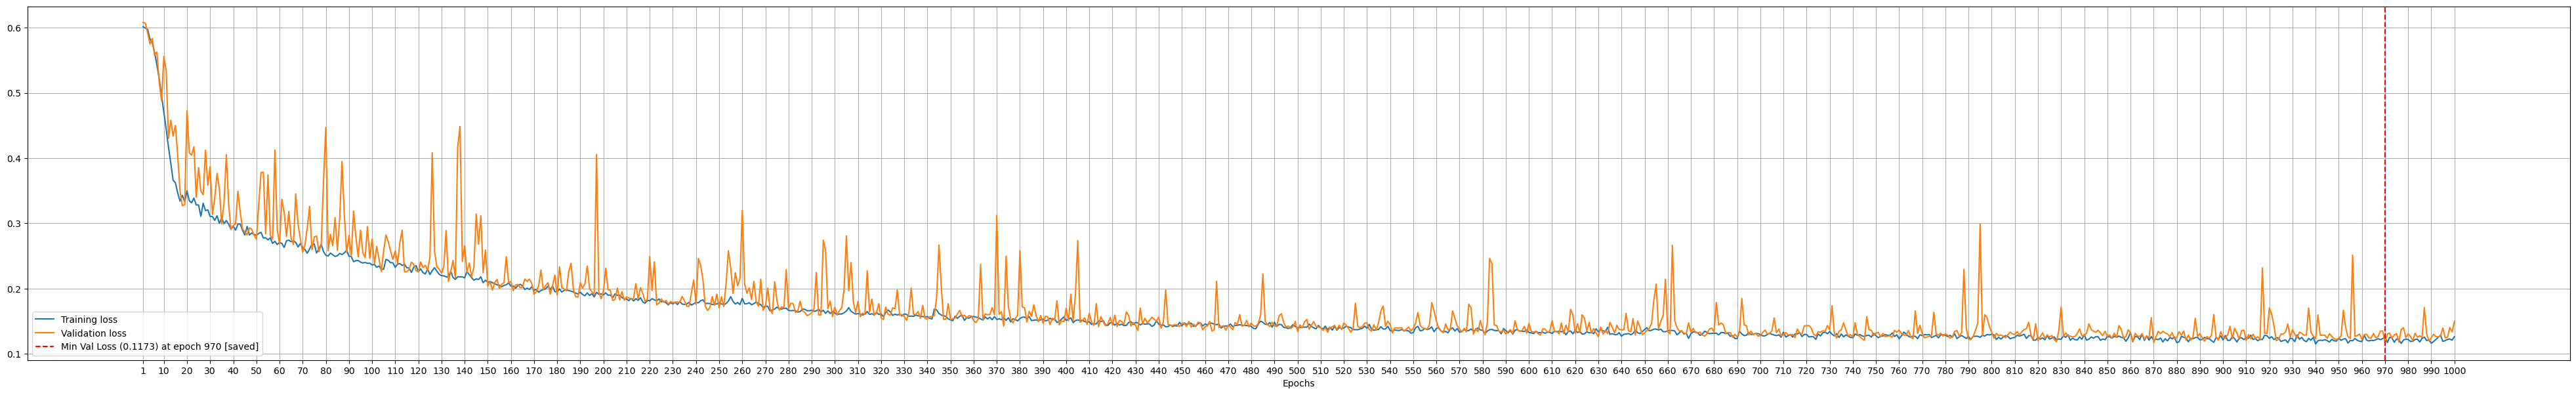

In [17]:
epochs_trained = len(history['train_loss'])
fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1, epochs_trained+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1, epochs_trained+1), history['val_loss'], label='Validation loss')

min_val_loss = min(history['val_loss'])
min_val_loss_epoch = history['val_loss'].index(min_val_loss) +1
plt.axvline(x=min_val_loss_epoch, color='red', linestyle='--', label=f'Min Val Loss ({min_val_loss:.4f}) at epoch {min_val_loss_epoch} [saved]')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)
#fig.autofmt_xdate()

plt.xlabel("Epochs")
plt.grid(True)
plt.legend()
plt.show()

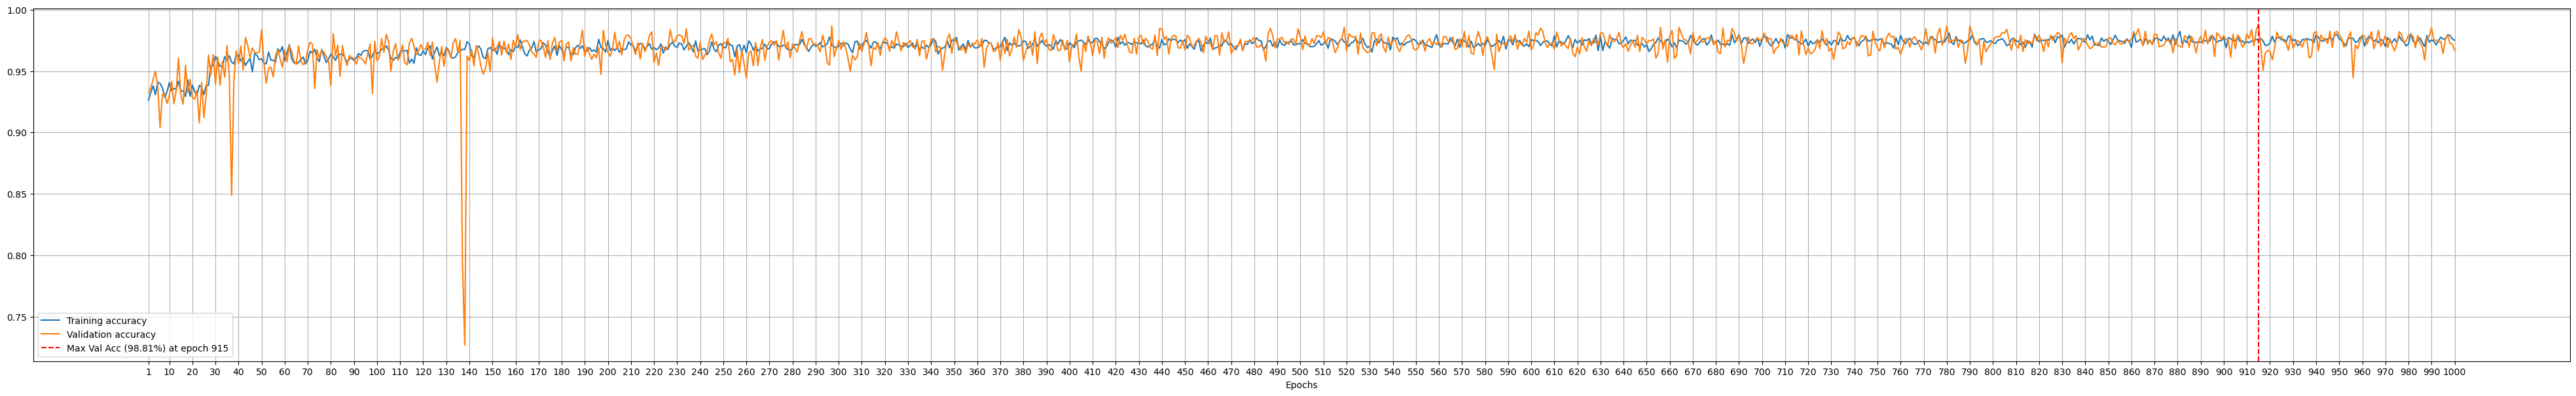

In [18]:
# from tensor to numpy
train_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['train_accuracy']]
val_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['val_accuracy']]
#print(train_accuracy_cpu)

fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1,epochs_trained+1), train_accuracy_cpu, label='Training accuracy')
plt.plot(np.arange(1,epochs_trained+1), val_accuracy_cpu, label='Validation accuracy')

max_val_acc = max(history['val_accuracy'])
max_val_acc_epoch = history['val_accuracy'].index(max_val_acc) +1
plt.axvline(x=max_val_acc_epoch, color='red', linestyle='--', label=f'Max Val Acc ({max_val_acc:.2f}%) at epoch {max_val_acc_epoch}')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)

#fig.autofmt_xdate()
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

**TEST**

In [19]:
# create model and load saved state 
# #model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)
# load_model_path = './trained_models/20250126_214831_UNet_0.06924
# model.load_state_dict(torch.load(load_model_path))
model.to(device)
model.eval()     # !!! set the dropout and batch normalization layers to evaluation mode

ViGUNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128

In [20]:
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # evaluation at native resolution
    # v2.RandomRotation(degrees=(-180, 180)),
    # v2.RandomHorizontalFlip(),
    # v2.RandomVerticalFlip(),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.GaussianNoise(),
    # v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 1)),
    #transforms.ToTensor(),    # already tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# load test images
test_img_dir = './data/CHASE/test/images'
test_gt_dir = './data/CHASE/test/2nd_manual'

test_dataset = Dataset(test_img_dir, test_gt_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [21]:
#check test image
for img, gt, img_name in test_loader:
    print(f"Shape of image: {img.shape}")
    print(f"Shape of GT: {gt.shape}")
    print(f"Name of image: {img_name[0]}") 
    break  # just one

Shape of image: torch.Size([1, 3, 512, 512])
Shape of GT: torch.Size([1, 1, 512, 512])
Name of image: 01_test.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


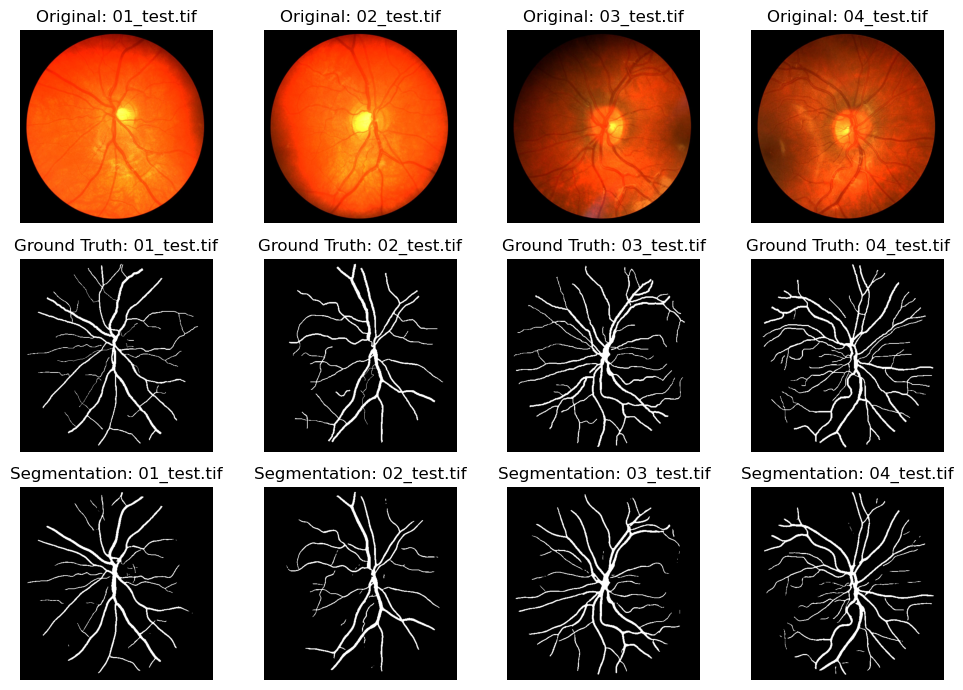

In [22]:
model.eval()   # done before, but just in case...

num_images = 4  # number of images to show
fig, axes = plt.subplots(3, num_images, figsize=(10, 7))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to cuda
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # convert to 0 or 1

        # convert output to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()

        # original test images
        axes[0, i].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # from tensor to image
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original: {image_name[0]}")
        
        # test images ground truth segmentations
        axes[1, i].imshow(gt_img, cmap='gray')  # grayscale
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Ground Truth: {image_name[0]}")

        # test images predicted segmentations
        axes[2, i].imshow(output_img, cmap='gray')  # grayscale
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Segmentation: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

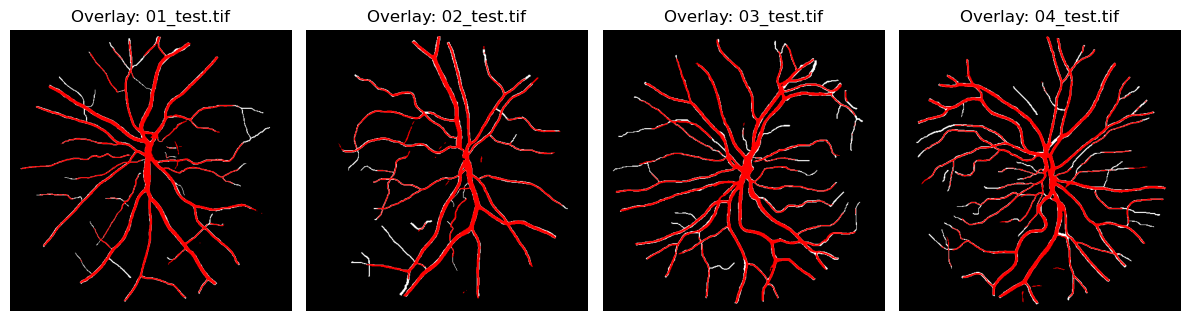

In [23]:
model.eval()   # done before, but just in case...

num_images = 4   # number of images to show
fig, axes = plt.subplots(1, num_images, figsize=(12, 8))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to CUDA
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # binarize prediction

        # convert prediction to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()  # gt as image

        # Mostrar ground truth como fondo en escala de grises
        axes[i].imshow(gt_img, cmap='gray')  # Fondo: ground truth
        
        # Crear imagen RGBA para superponer
        overlay = np.zeros((*output_img.shape, 4))  # Crear un mapa RGBA
        overlay[..., 0] = 1  # Canal rojo
        overlay[..., 3] = output_img  # Canal alfa (0 para transparente, 1 para opaco)
        
        axes[i].imshow(overlay)  # Superposición en RGBA
        
        axes[i].axis('off')
        axes[i].set_title(f"Overlay: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

**ROC, AUC, Test Accuracy, Dice score, MCC, ccDice**


Dice score: 0.8134

MCC: 0.8009

ccDice score: 0.1668

Test Accuracy: 0.9751

F1 Score: 0.8133




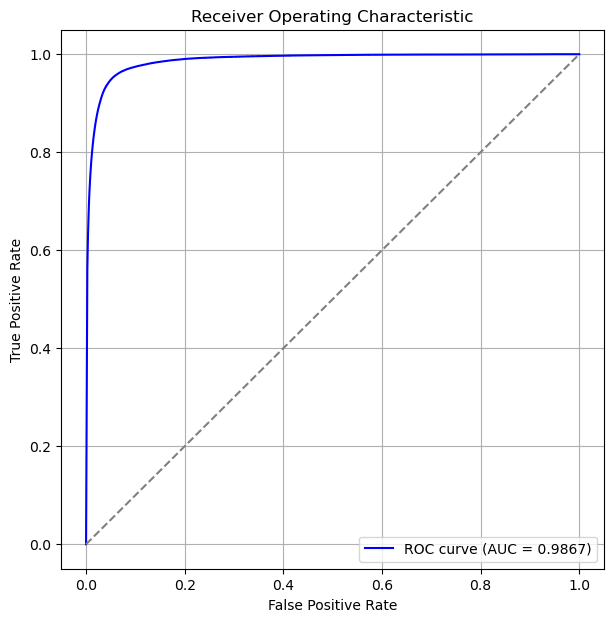

In [24]:
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from utils.dice_score import dice_score                     # custom function to calculate dice score
from utils.matthews_corr_coef import matthews_corr_coef     # custom function to calculate MCC
from utils.ccDice_score import ccDice                       # modified ccDice score (only binary labels)
from skimage.measure import label                           # necessary for ccDice

calculate_ccdice = True    # yes or no. Forced to use CPU: it takes long to compute (5 minutes just 8 images)

all_labels = []       # to store ground truth values for each pixel of each image
all_preds = []        # to store predicted values for each pixel of each image

dice_score_batches = []       # to store Dice score of each batch
mcc_batches = []              # to store MCC of each batch
if calculate_ccdice==True:
    ccdice_score_batches = []     # to store ccDice score of each batch

with torch.no_grad():  # no gradients needed
    for inputs, ground_truth, _ in test_loader:        # for each batch in test loader
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)

        outputs = model(inputs)     # predict

        all_labels.append(ground_truth.cpu().numpy())       # real labels for each pixel (0 or 1) 
        all_preds.append(outputs.cpu().numpy())             # probabilities to belong to class 1, given by model
        
        dice = dice_score(outputs, ground_truth, threshold=0.5)
        dice_score_batches.append(dice.item())
        
        mcc = matthews_corr_coef(outputs, ground_truth, threshold=0.5)
        mcc_batches.append(mcc)

        if calculate_ccdice==True:
            y_pred_label, cc_pred = label(((outputs > 0.5).float()).cpu().numpy().squeeze(0), return_num=True)
            y_true_label, cc_true = label(ground_truth.cpu().numpy().squeeze(0), return_num=True)
            ccdice = ccDice(y_pred_label, cc_pred, y_true_label, cc_true, alpha=0.1)    # alpha is level of exigency to join 2 cc (low is permissive, 1.0 is max exigency)
            ccdice_score_batches.append(ccdice)

# compute mean dice score and print
mean_dice_score = torch.tensor(dice_score_batches).mean()
print(f"\nDice score: {mean_dice_score:.4f}")

# compute mean MCC and print
mean_mcc = torch.tensor(mcc_batches).mean()
print(f"\nMCC: {mean_mcc:.4f}")

# compute mean ccDice score and print
if calculate_ccdice==True:
    mean_ccdice_score = torch.tensor(ccdice_score_batches).mean()
    print(f"\nccDice score: {mean_ccdice_score:.4f}")

# list to numpy array
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# compute mean test accuracy and print
accuracy_sklearn = accuracy_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nTest Accuracy: {accuracy_sklearn:.4f}")

# compute mean F1 score accuracy and print
f1_sklearn = f1_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nF1 Score: {f1_sklearn:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(list(map(bool,all_labels.flatten())), all_preds.flatten())     # force labels to binary list (if not, error when transform.resize)

# AUC
roc_auc = auc(fpr, tpr)

# plot ROC
print("\n")
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

trained_models\20250205_182055_ViGUNet_0.05962

In [25]:
# just to visualize the model architecture

'''from torch.utils.tensorboard import SummaryWriter
import torchvision

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/UNet')

# get some random training images
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

print(images.shape)
images = images.to(device)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

#img_grid = img_grid.unsqueeze(0) 

# write to tensorboard
writer.add_image('train_img', img_grid)

writer.add_graph(model, images)
writer.close()

# write in terminal --->   tensorboard --logdir=runs/Unet'''

'from torch.utils.tensorboard import SummaryWriter\nimport torchvision\n\n# default `log_dir` is "runs" - we\'ll be more specific here\nwriter = SummaryWriter(\'runs/UNet\')\n\n# get some random training images\ndataiter = iter(train_loader)\nimages, labels, _ = next(dataiter)\n\nprint(images.shape)\nimages = images.to(device)\n\n# create grid of images\nimg_grid = torchvision.utils.make_grid(images)\n\n#img_grid = img_grid.unsqueeze(0) \n\n# write to tensorboard\nwriter.add_image(\'train_img\', img_grid)\n\nwriter.add_graph(model, images)\nwriter.close()\n\n# write in terminal --->   tensorboard --logdir=runs/Unet'